# Diagnostics on  SXDS prototype run with LSST science pipelines

Here we will look at the full SXDS catalogue. This first run only included circular aperture, PSF, and Gaussian model photometry. We will predominantly be comparing to the Oxford produced SExtractor VISTA-Ks selected catalogues. Likewise the first LSST Pipeline runs were based on Ks selected sources. We also impose a s/n > 5 cut on the VISTA-Ks 12 pixell crcular aperture fluxes.

In [1]:
import numpy as np
from scipy import stats

from collections import OrderedDict

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, vstack
import astropy.units as u
from astropy import visualization as vz

import os
from collections import OrderedDict
import yaml
import glob
import numpy as np


import matplotlib
import matplotlib.gridspec as gridspec 
import matplotlib.pyplot as plt
%matplotlib inline

from lsst.geom import degrees
import lsst.daf.persistence as dafPersist

import warnings
warnings.filterwarnings('ignore')


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

In [2]:
os.getcwd()

'/Users/raphaelshirley/Documents/github/lsst-ir-fusion/dmu5/dmu5_VHS'

In [3]:
#DMU = '/Volumes/Raph500/lsst-ir-fusion'
DMU = '/Users/raphaelshirley/Documents/github/lsst-ir-fusion'
RED_CAT = './data/w02_full_reduced_cat_3996.fits'
OXFORD_VISTA_Ks_CAT = "../../dmu3/data/XMMFULL_DR2_MASKVISTA_Ks_2.0as_IRAC2.8as_2020_06_01.fits"
HELP_CAT = "../../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits"

In [8]:
allBands = ['HSC_{}'.format(b) for b in ['G', 'R', 'I', 'Z', 'Y']]
allBands += (['VISTA_{}'.format(b) for b in ['J', 'H', 'Ks']])
allBands

['HSC_G', 'HSC_R', 'HSC_I', 'HSC_Z', 'HSC_Y', 'VISTA_J', 'VISTA_H', 'VISTA_Ks']

## LSST Science Pipeline SXDS full catalogue

This catalogue is missing a few patches due to Slurm failures. I am not rerunning them for now as they wont provide much greater statistics.

Circular aperture fluxes are not curve of growth corrected. 

In [9]:
cols=[
    'id', 
    'VISTA_Ks_m_coord_ra', 
    'VISTA_Ks_m_coord_dec',
    'VISTA_Ks_m_detect_isPatchInner',
    'VISTA_Ks_m_detect_isTractInner',
    #'VISTA_Ks_m_base_ClassificationExtendedness_value',
    #'VISTA_Ks_m_merge_peak_sky'
]

for b in allBands:
    cols += [
        '{}_m_base_CircularApertureFlux_12_0_mag'.format(b),
        '{}_m_base_CircularApertureFlux_12_0_magErr'.format(b),
        '{}_m_base_CircularApertureFlux_6_0_mag'.format(b),
        '{}_m_base_CircularApertureFlux_6_0_magErr'.format(b),
        '{}_m_base_CircularApertureFlux_9_0_mag'.format(b),
        '{}_m_base_PsfFlux_mag'.format(b),
        '{}_m_base_PsfFlux_magErr'.format(b)
    ]

In [10]:
cols

['id',
 'VISTA_Ks_m_coord_ra',
 'VISTA_Ks_m_coord_dec',
 'VISTA_Ks_m_detect_isPatchInner',
 'VISTA_Ks_m_detect_isTractInner',
 'HSC_G_m_base_CircularApertureFlux_12_0_mag',
 'HSC_G_m_base_CircularApertureFlux_12_0_magErr',
 'HSC_G_m_base_CircularApertureFlux_6_0_mag',
 'HSC_G_m_base_CircularApertureFlux_6_0_magErr',
 'HSC_G_m_base_CircularApertureFlux_9_0_mag',
 'HSC_G_m_base_PsfFlux_mag',
 'HSC_G_m_base_PsfFlux_magErr',
 'HSC_R_m_base_CircularApertureFlux_12_0_mag',
 'HSC_R_m_base_CircularApertureFlux_12_0_magErr',
 'HSC_R_m_base_CircularApertureFlux_6_0_mag',
 'HSC_R_m_base_CircularApertureFlux_6_0_magErr',
 'HSC_R_m_base_CircularApertureFlux_9_0_mag',
 'HSC_R_m_base_PsfFlux_mag',
 'HSC_R_m_base_PsfFlux_magErr',
 'HSC_I_m_base_CircularApertureFlux_12_0_mag',
 'HSC_I_m_base_CircularApertureFlux_12_0_magErr',
 'HSC_I_m_base_CircularApertureFlux_6_0_mag',
 'HSC_I_m_base_CircularApertureFlux_6_0_magErr',
 'HSC_I_m_base_CircularApertureFlux_9_0_mag',
 'HSC_I_m_base_PsfFlux_mag',
 'HSC_I_m

In [11]:
cat = Table.read(RED_CAT)[cols]

cat['ra']=cat['VISTA_Ks_m_coord_ra']
cat['dec']=cat['VISTA_Ks_m_coord_dec']

#for c in cat.colnames:
    #cat[c].name = c.replace('-','_')
#cat.meta=None

In [111]:
cat[:10]

<Table length=10>
        id         VISTA_Ks_m_coord_ra ...         dec         
                           rad         ...         rad         
      int64              float64       ...       float64       
------------------ ------------------- ... --------------------
171189562398214108  0.5062054453747795 ...  0.02597078327761381
171189562398214145  0.5057753541679613 ... 0.025966039162512725
171189562398214150  0.5059268684432372 ... 0.025976575541898618
171189562398214152    0.50585518876371 ... 0.025980670392603697
171189562398214155  0.5062453685304379 ...  0.02599031265939163
171189562398214156  0.5058837105046073 ...  0.02600508967057629
171189562398214157  0.5052882500110398 ... 0.025986551002588273
171189562398214158  0.5052124935452199 ... 0.025984945918376304
171189562398214161  0.5051155653668296 ... 0.025999633054270874
171189562398214164  0.5056922875513364 ... 0.026005966059549246

In [12]:
len(cat)

986098

In [112]:
np.sum(cat['VISTA_Ks_m_base_CircularApertureFlux_12_0_magErr']<1000)

631310

In [113]:
np.sum(cat['VISTA_Ks_m_base_CircularApertureFlux_12_0_mag']/cat['VISTA_Ks_m_base_CircularApertureFlux_12_0_magErr']>5)

624348

In [13]:
!mkdir figs

In [14]:
apDiff = cat['HSC_G_m_base_CircularApertureFlux_9_0_mag'] - cat['HSC_G_m_base_CircularApertureFlux_6_0_mag']
m = apDiff > -0.75
m &= apDiff < 0

In [15]:
np.sum(m)

595504

Text(0.5, 0, 'HSC-G 9pix - 6pix aperture [mag]')

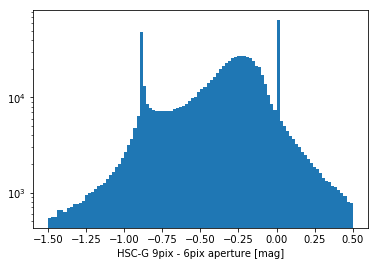

In [16]:
plt.hist(apDiff,range=[-1.5,0.5],bins=100)
plt.yscale('log')
#plt.xlim([-1.5,0.5])
plt.xlabel('HSC-G 9pix - 6pix aperture [mag]')

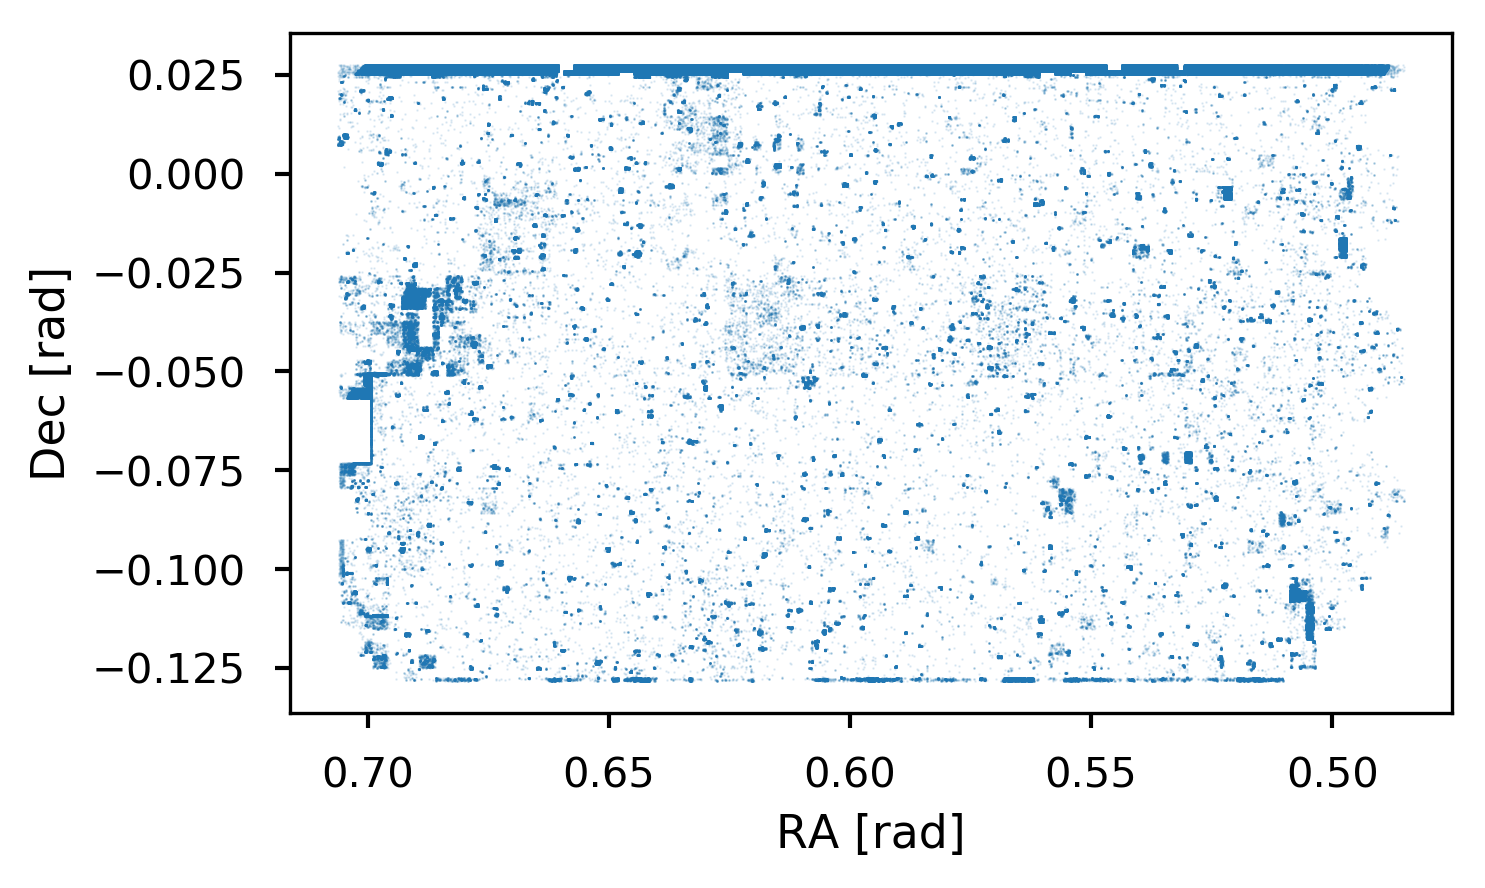

In [107]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)

im = ax.scatter(
    cat['VISTA_Ks_m_coord_ra'],cat['VISTA_Ks_m_coord_dec'],
   # c=cat[''],
    s=0.1,alpha=0.1, rasterized=True)
#fig.colorbar(im, ax=ax).set_label('All positions')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(cat['VISTA_Ks_m_coord_ra'])+0.01, np.min(cat['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_9-6_HSC-G.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_9-6_HSC-G.png', bbox_inches='tight')

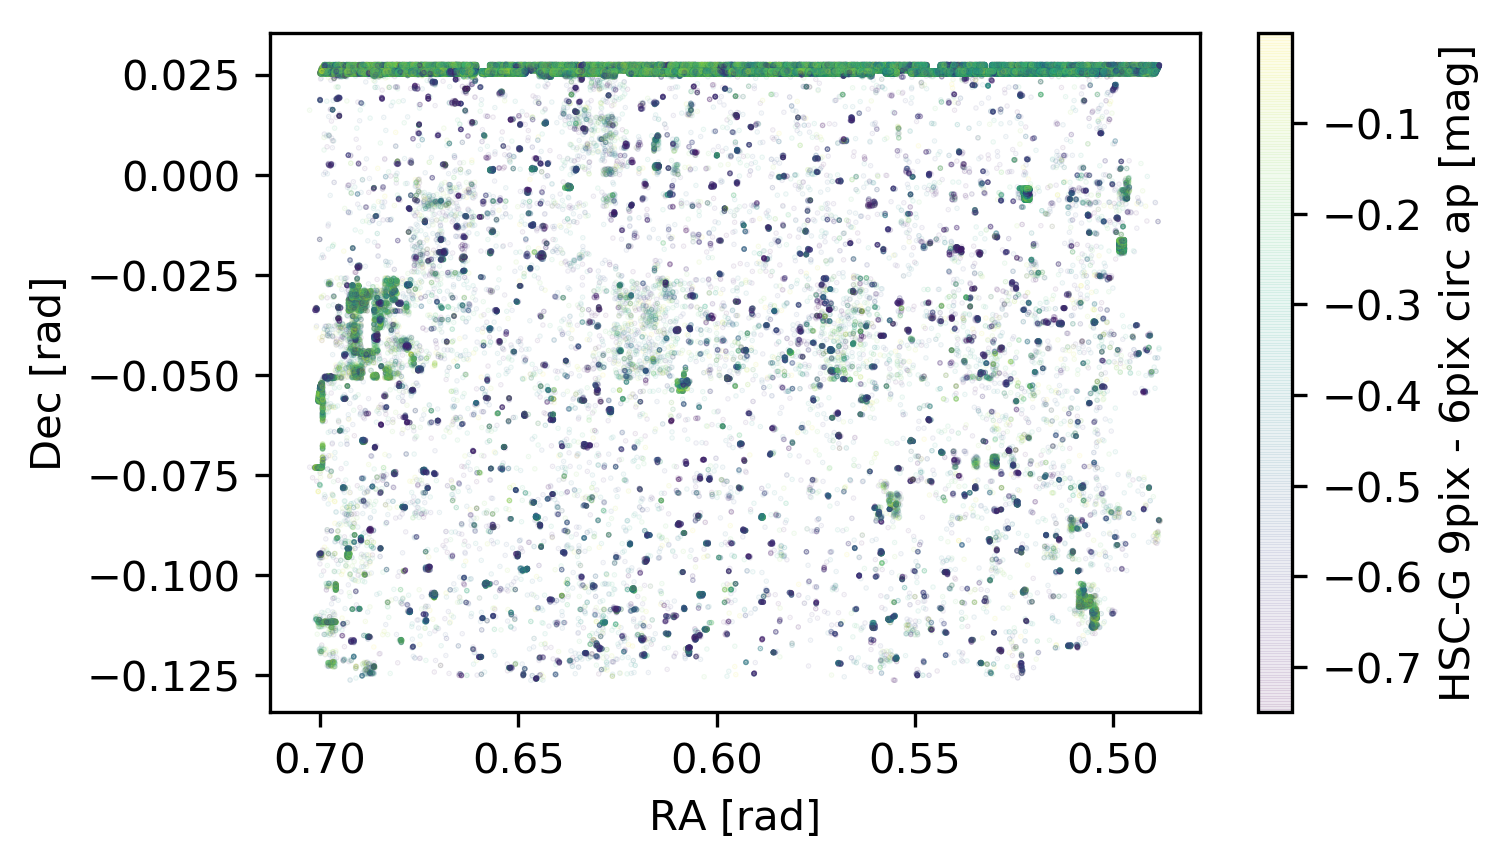

In [17]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)

im = ax.scatter(
    cat[m]['VISTA_Ks_m_coord_ra'],cat[m]['VISTA_Ks_m_coord_dec'],
    c=apDiff[m],
    s=0.1,alpha=0.1, rasterized=True)
fig.colorbar(im, ax=ax).set_label('HSC-G 9pix - 6pix circ ap [mag]')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(cat[m]['VISTA_Ks_m_coord_ra'])+0.01, np.min(cat[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_9-6_HSC-G.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_9-6_HSC-G.png', bbox_inches='tight')

In [19]:
#aperture pix (radius) to arcsec
np.array([6,9,12,17])*0.168

array([1.008, 1.512, 2.016, 2.856])

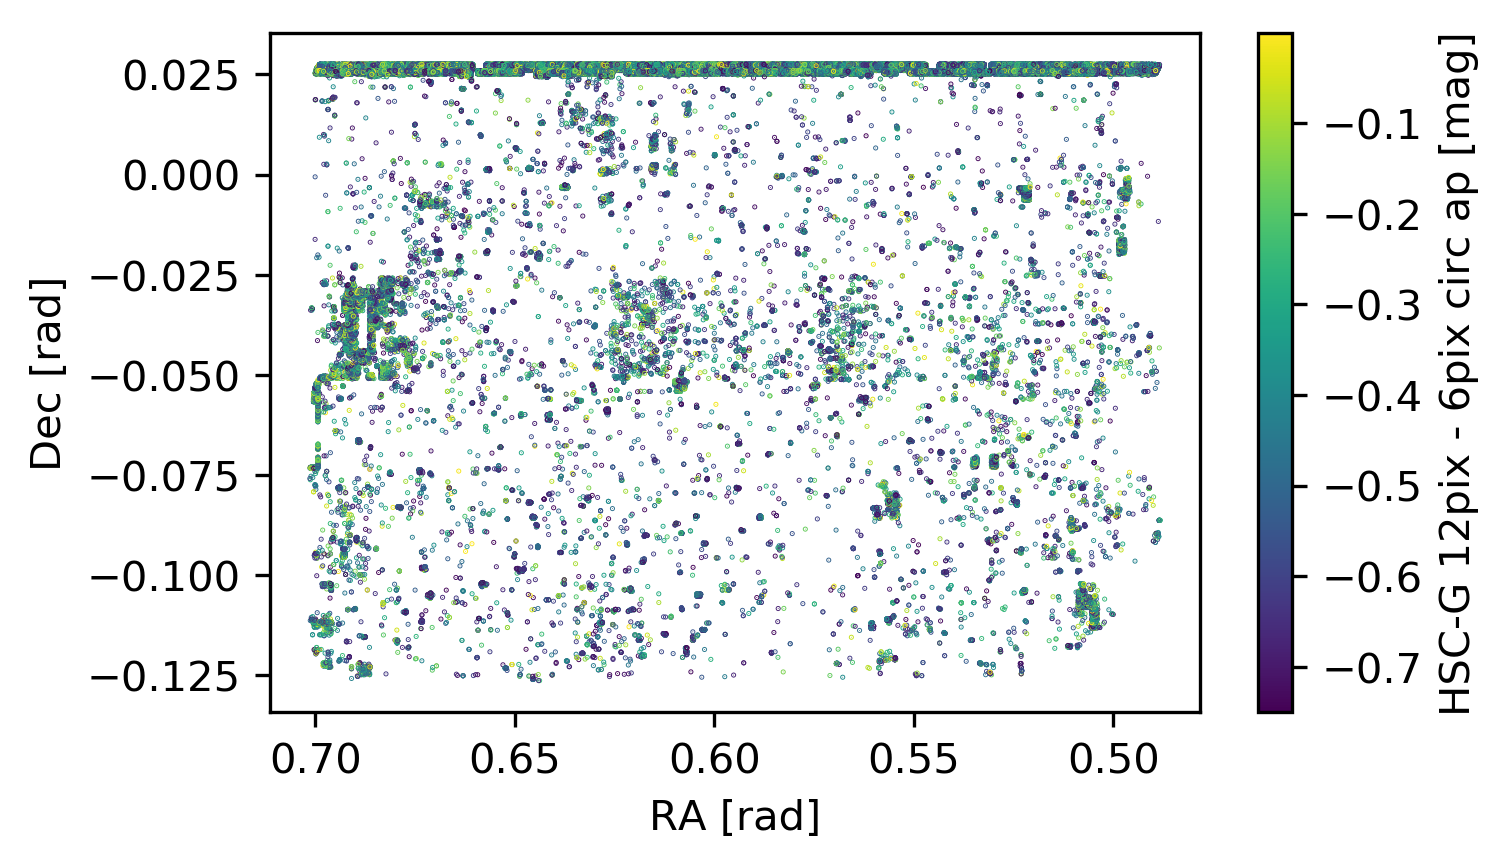

In [20]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
apDiff = cat['HSC_G_m_base_CircularApertureFlux_12_0_mag'] - cat['HSC_G_m_base_CircularApertureFlux_6_0_mag']
m = apDiff > -0.75
m &= apDiff < 0
im = ax.scatter(cat[m]['VISTA_Ks_m_coord_ra'],cat[m]['VISTA_Ks_m_coord_dec'],c=apDiff[m],
                s=0.05,alpha=1., rasterized=True)
fig.colorbar(im, ax=ax).set_label('HSC-G 12pix - 6pix circ ap [mag]')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(cat[m]['VISTA_Ks_m_coord_ra'])+0.01, np.min(cat[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_12-6_HSC-G.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_12-6_HSC-G.png', bbox_inches='tight')

Text(0.5, 0, 'HSC-G 12pix - 6pix aperture [mag]')

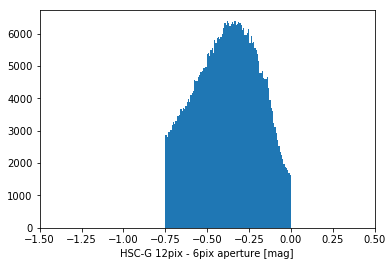

In [21]:
plt.hist(apDiff[m],bins=100)
plt.xlim([-1.5,0.5])
plt.xlabel('HSC-G 12pix - 6pix aperture [mag]')

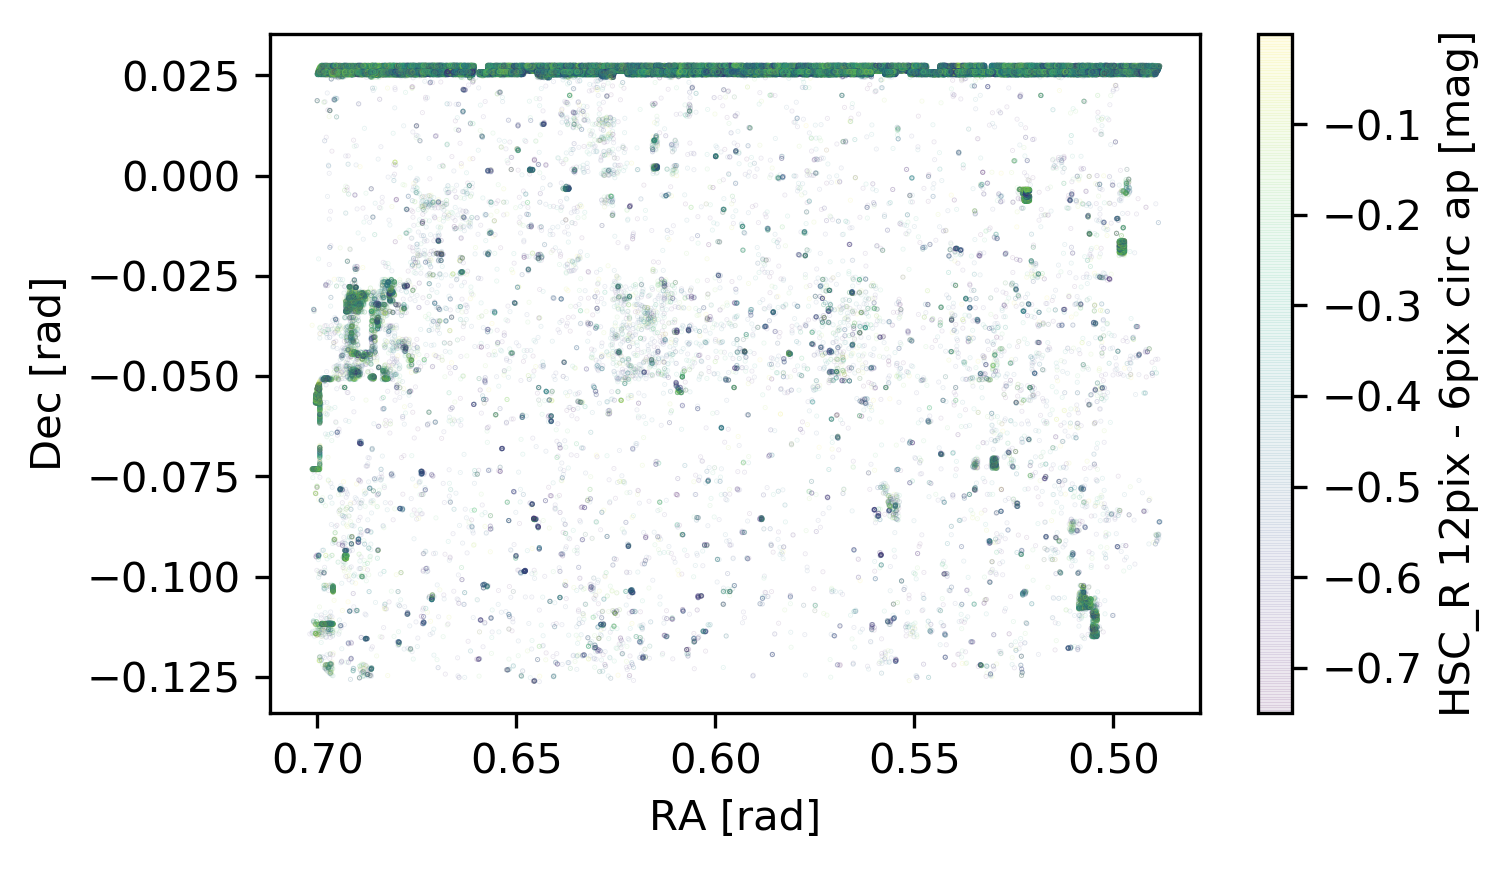

In [22]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
apDiff = cat['HSC_R_m_base_CircularApertureFlux_12_0_mag'] - cat['HSC_R_m_base_CircularApertureFlux_6_0_mag']
m = apDiff > -0.75
m &= apDiff < 0
im = ax.scatter(cat[m]['VISTA_Ks_m_coord_ra'],cat[m]['VISTA_Ks_m_coord_dec'],c=apDiff[m],
                s=0.05,alpha=0.1, rasterized=True)
fig.colorbar(im, ax=ax).set_label('HSC_R 12pix - 6pix circ ap [mag]')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(cat[m]['VISTA_Ks_m_coord_ra'])+0.01, np.min(cat[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_12-6_HSC-R.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_12-6_HSC-R.png', bbox_inches='tight')

Text(0.5, 0, 'HSC-R 12pix - 6pix aperture [mag]')

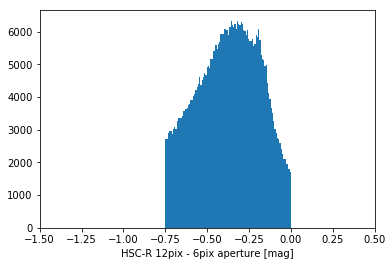

In [23]:
plt.hist(apDiff[m],bins=100)
plt.xlim([-1.5,0.5])
plt.xlabel('HSC-R 12pix - 6pix aperture [mag]')

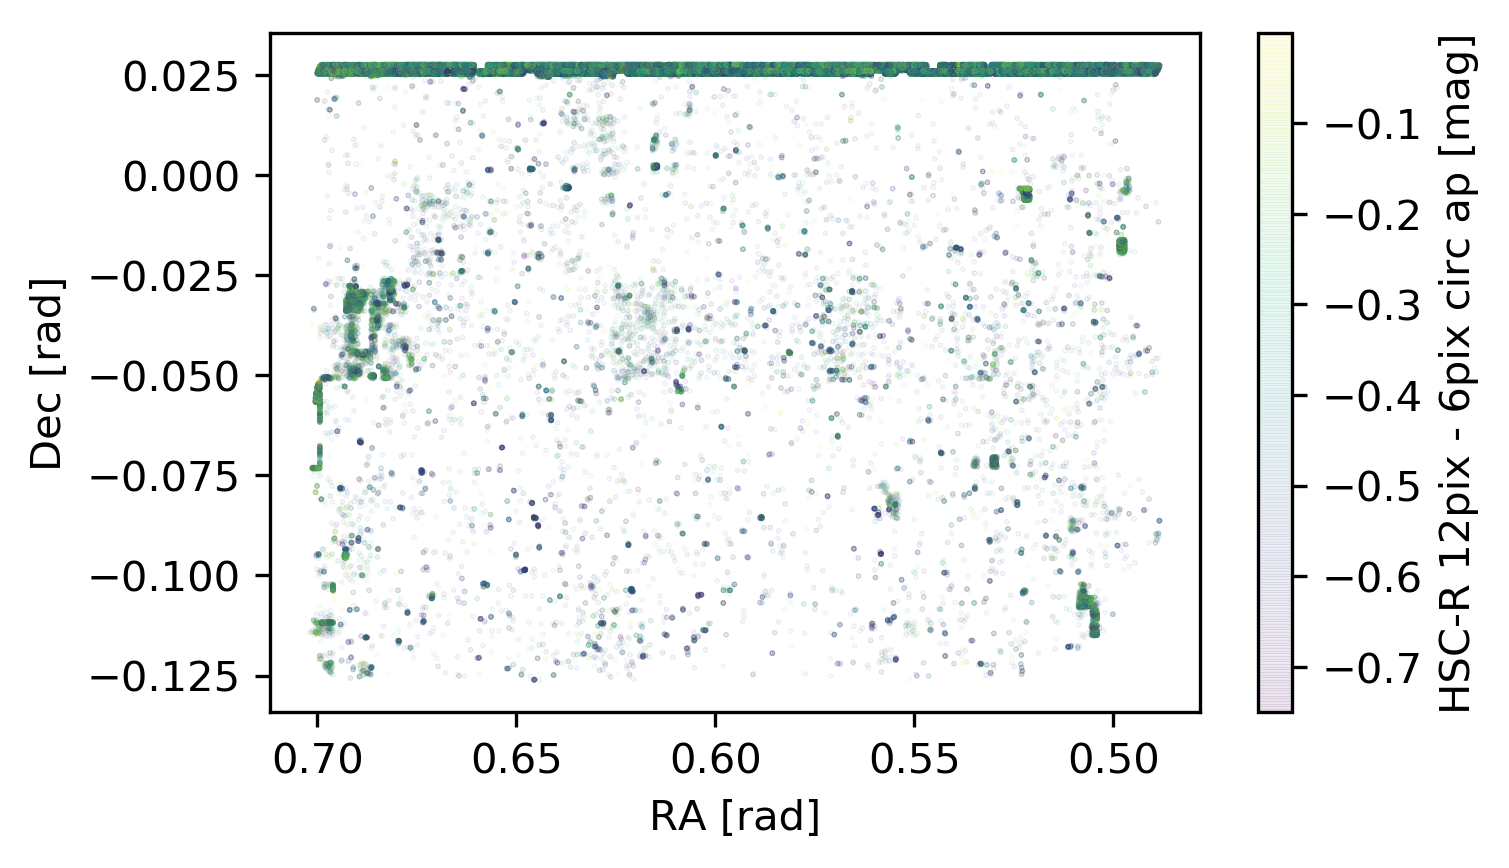

In [24]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
apDiff = cat['HSC_R_m_base_CircularApertureFlux_12_0_mag'] - cat['HSC_R_m_base_CircularApertureFlux_6_0_mag']
m = apDiff > -0.75
m &= apDiff < 0
im = ax.scatter(cat[m]['VISTA_Ks_m_coord_ra'],cat[m]['VISTA_Ks_m_coord_dec'],c=apDiff[m],
                s=0.1,alpha=0.1, rasterized=True)
fig.colorbar(im, ax=ax).set_label('HSC-R 12pix - 6pix circ ap [mag]')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(cat[m]['VISTA_Ks_m_coord_ra'])+0.01, np.min(cat[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_12-6_HSC-R.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_12-6_HSC-R.png', bbox_inches='tight')

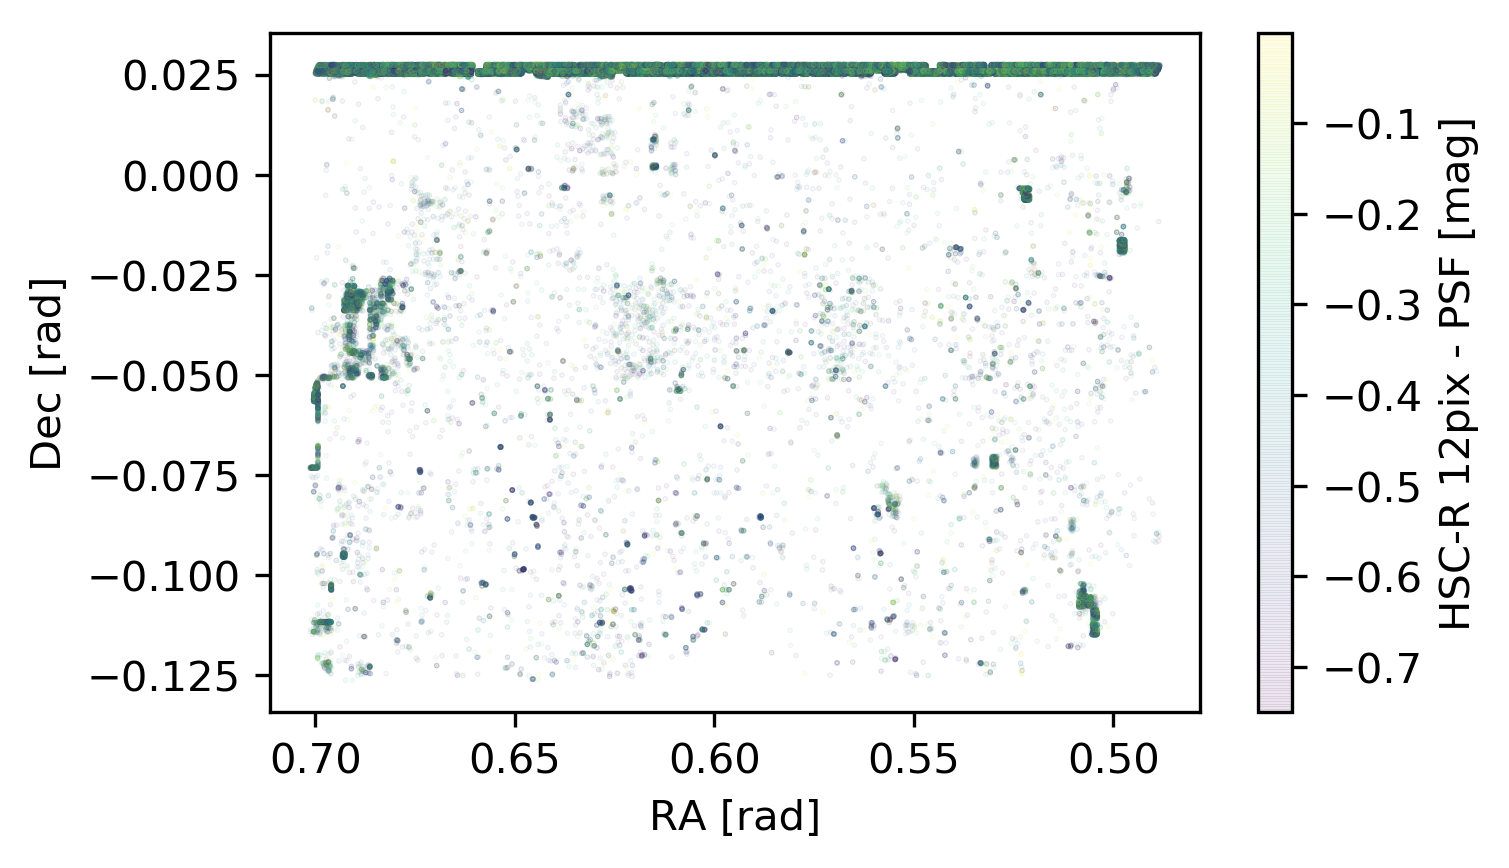

In [25]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
apDiff = cat['HSC_R_m_base_CircularApertureFlux_12_0_mag'] - cat['HSC_R_m_base_PsfFlux_mag']
m = apDiff > -0.75
m &= apDiff < 0
im = ax.scatter(cat[m]['VISTA_Ks_m_coord_ra'],cat[m]['VISTA_Ks_m_coord_dec'],c=apDiff[m],
                s=0.1,alpha=0.1, rasterized=True)
fig.colorbar(im, ax=ax).set_label('HSC-R 12pix - PSF [mag]')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(cat[m]['VISTA_Ks_m_coord_ra'])+0.01, np.min(cat[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_12-psf_HSC-R.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_12-psf_HSC-R.png', bbox_inches='tight')

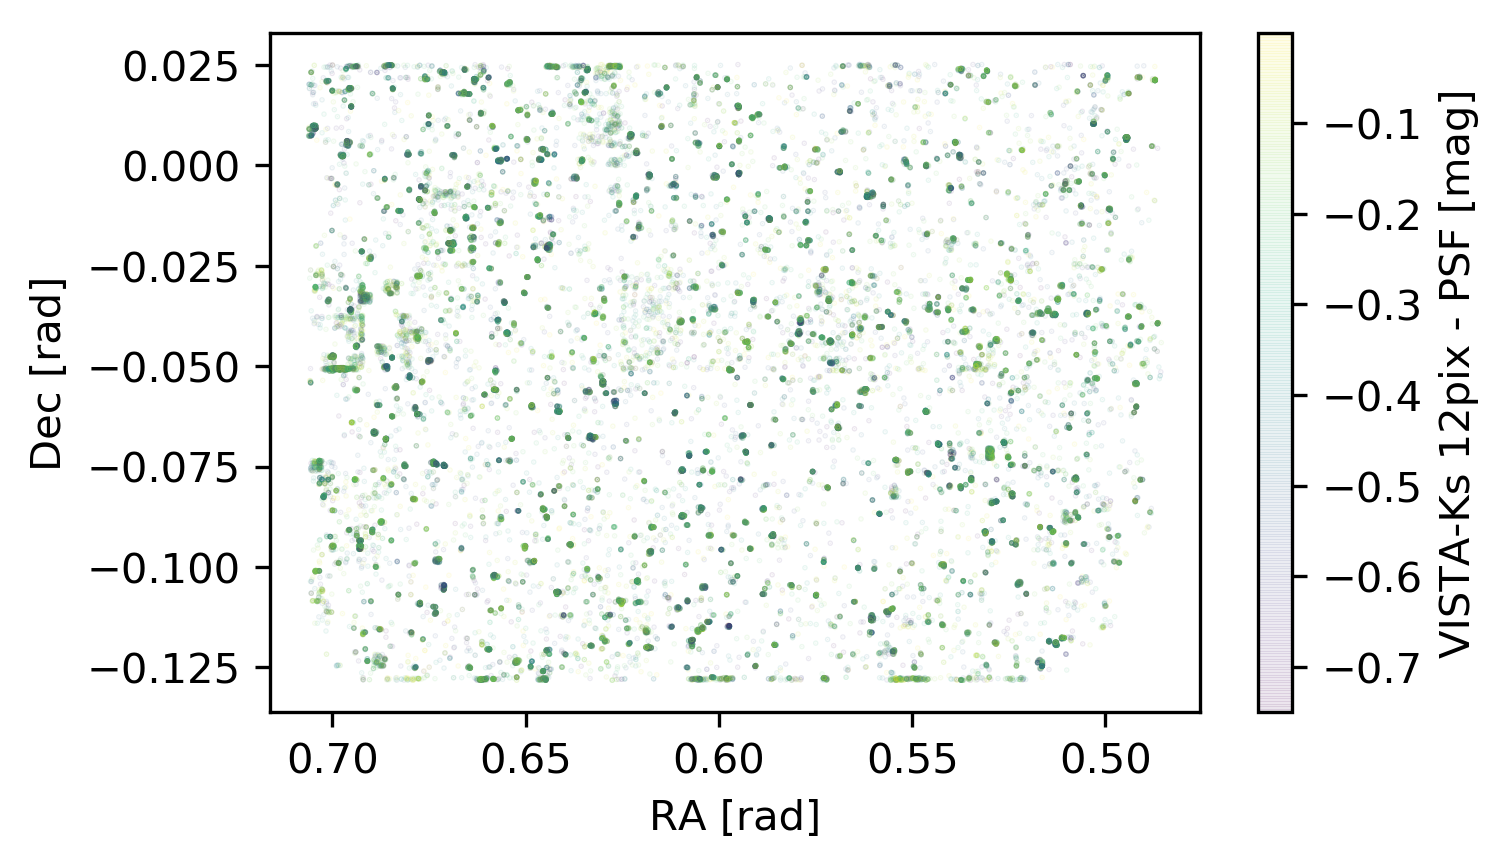

In [26]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=300)
apDiff = cat['VISTA_Ks_m_base_CircularApertureFlux_12_0_mag'] - cat['VISTA_Ks_m_base_PsfFlux_mag']
m = apDiff > -0.75
m &= apDiff < 0
im = ax.scatter(cat[m]['VISTA_Ks_m_coord_ra'],cat[m]['VISTA_Ks_m_coord_dec'],c=apDiff[m],
                s=0.1,alpha=0.1, rasterized=True)
fig.colorbar(im, ax=ax).set_label('VISTA-Ks 12pix - PSF [mag]')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(cat[m]['VISTA_Ks_m_coord_ra'])+0.01, np.min(cat[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_12-psf_VISTA-Ks.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_12-psf_VISTA-Ks.png', bbox_inches='tight')

## Oxford Ks selected 2 arcsec aperture catalogue

In [27]:
#From email from Manda
oxfordApCorr = {
    'HSC_G_2as':0.1765,
    'HSC_G_3as':0.0788,
    'HSC_R_2as':0.1638,
    'HSC_R_3as':0.0905,
    'HSC_I_2as':0.1512,
    'HSC_I_3as':0.0788,
    'HSC_Z_2as':0.2155,
    'HSC_Z_3as':0.1144,
    'HSC_Y_2as':0.2023,
    'HSC_Y_3as':0.1144,
    'VISTA_Z_2as':0.3567,
    'VISTA_Z_3as':0.2023,
    'VISTA_Y_2as':0.3567,
    'VISTA_Y_3as':0.2023,
    'VISTA_J_2as':0.2980,
    'VISTA_J_3as':0.1765,
    'VISTA_H_2as':0.2423,
    'VISTA_H_3as':0.1512,
    'VISTA_Ks_2as':0.2288,
    'VISTA_Ks_3as':0.1388}

In [28]:
def flux_to_mag(fluxes, errors_on_fluxes=None):
    """Convert fluxes and errors to magnitudes
    Given flux densities in Jy with associated errors, this function returns
    the corresponding AB magnitudes en errors.
    The magnitudes are computed with this formula:
        M = 2.5 * (23 - log10(F)) - 48.6
    and the errors on magnitudes with this one
        M_err = 2.5/ln(10) * F_err / F
    Parameters
    ----------
    fluxes: float or array-like of floats
        The fluxes in Jy.
    errors_on_fluxes: float or array-like of floats
        The flux errors in Jy None if there are no errors.
    Returns
    -------
    magnitudes: float or array-like of floats
        The AB magnitudes.
    errors: float or array-like of floats
        The errors on AB magnitudes.
    """
    fluxes = np.array(fluxes)
    magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6

    if errors_on_fluxes is not None:
        errors_on_fluxes = np.array(errors_on_fluxes)
        errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes
    else:
        errors = None

    return magnitudes, errors

In [29]:
def mag_to_flux(magnitudes, errors_on_magnitudes=None):
    """Convert AB magnitudes and errors to fluxes
    Given AB magnitudes and associated errors, this function returns the
    corresponding fluxes and associated flux errors (in Jy).
    The fluxes are computed with this formula:
        F = 10^((8.9 - Mag)/2.5)
    and the errors on fluxes with this one:
        F_err = ln(10)/2.5 * F * Mag_err
    Parameters
    ----------
    magnitudes: float or array-like of floats
        AB magnitudes of the sources.
    errors_on_magnitudes: float or array-like of floats
        Error on each magnitudes. None if there are no errors.
    Returns
    -------
    fluxes: float or array-like of floats
        The fluxes in Jy.
    errors: float or array-like of floats
        The errors on fluxes in Jy or None.
    """
    magnitudes = np.array(magnitudes)
    fluxes = 10 ** ((8.9 - magnitudes)/2.5)

    if errors_on_magnitudes is not None:
        errors_on_magnitudes = np.array(errors_on_magnitudes)
        errors = np.log(10)/2.5 * fluxes * errors_on_magnitudes
    else:
        errors = None

    return fluxes, errors

In [30]:
imported_columns = OrderedDict({
        'ID_se':              'id', 
        'RA':     'ra', 
        'DEC':     'dec', 
    
        #'J_CLASS_STAR':    'vista_stellarity', 
        'flux_HSC-G':    'f_ap_hsc_g', 
        'err_HSC-G':     'ferr_ap_hsc_g',
        'flux_HSC-R':    'f_ap_hsc_r', 
        'err_HSC-R':     'ferr_ap_hsc_r',
        'flux_HSC-I':    'f_ap_hsc_i', 
        'err_HSC-I':     'ferr_ap_hsc_i',
        'flux_HSC-Z':    'f_ap_hsc_z', 
        'err_HSC-Z':     'ferr_ap_hsc_z',
        'flux_HSC-Y':    'f_ap_hsc_y', 
        'err_HSC-Y':     'ferr_ap_hsc_y',
    
        'flux_Z':    'f_ap_vista_z', 
        'err_Z': 'ferr_ap_vista_z', 
    
        'flux_Y':    'f_ap_vista_y', 
        'err_Y': 'ferr_ap_vista_y', 

    
        'flux_J':    'f_ap_vista_j', 
        'err_J': 'ferr_ap_vista_j', 

    
        'flux_H':    'f_ap_vista_h', 
        'err_H': 'ferr_ap_vista_h', 

  
        'flux_Ks':    'f_ap_vista_ks', 
        'err_Ks': 'ferr_ap_vista_ks', 


})


oxford_ks_cat = Table.read(OXFORD_VISTA_Ks_CAT
                      )[list(imported_columns)]


for column in imported_columns:
    oxford_ks_cat[column].name = 'oxford_ks_' + imported_columns[column]
    

    
oxford_ks_cat['oxford_ks_ra'].unit = u.deg
oxford_ks_cat['oxford_ks_dec'].unit = u.deg
oxford_ks_cat['oxford_ks_ra'].convert_unit_to(u.rad)
oxford_ks_cat['oxford_ks_dec'].convert_unit_to(u.rad)
oxford_ks_cat['oxford_ks_ra_temp'] = oxford_ks_cat['oxford_ks_ra']
oxford_ks_cat['oxford_ks_dec_temp'] = oxford_ks_cat['oxford_ks_dec']
print(len(oxford_ks_cat))



1674689


In [31]:
for col in oxford_ks_cat.colnames:
    if col.startswith('oxford_ks_f_'):
        err_col = col.replace('_f_', '_ferr_')
        oxford_ks_cat[col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_ks_cat[err_col].unit = u.erg/u.second/u.cm**2/u.Hz
        oxford_ks_cat[col].convert_unit_to(u.uJy)
        oxford_ks_cat[err_col].convert_unit_to(u.uJy)
        m,merr = flux_to_mag(oxford_ks_cat[col]*1e-6,oxford_ks_cat[err_col]*1e-6) # expects Jansky
        oxford_ks_cat[col.replace('_f_', '_m_')] = m
        oxford_ks_cat[err_col.replace('_ferr_', '_merr_')] = merr
        oxford_ks_cat.remove_columns([col,err_col])
        
for col in oxford_ks_cat.colnames:
    if col.startswith('oxford_ks_merr_ap_'):
        mask = np.isnan(oxford_ks_cat[col.replace('_merr_','_m_')])
        oxford_ks_cat[col][mask] = np.nan

In [32]:
oxford_ks_cat[:5]

<Table length=5>
oxford_ks_id oxford_ks_ra ... oxford_ks_m_ap_vista_ks oxford_ks_merr_ap_vista_ks
                 rad      ...                                                   
   int32       float64    ...         float64                  float64          
------------ ------------ ... ----------------------- --------------------------
      610230    0.5907544 ...      23.191595148598587         0.3486519490883467
      128492    0.5907544 ...      23.713185441998085         0.5757357015911263
      451090    0.5907545 ...       22.79896338529968        0.21297468202846717
      173887    0.5907545 ...       23.52062543977548         0.4657953973972276
       69787    0.5907545 ...        21.2813477685553        0.05563409496144291

In [33]:
vega_to_ab = {
    "z":0.502,  #D2 in Fernandez-Gonzalez 2018
    "y":0.600,  #D3
    "j":0.916,  #D4
    "h":1.366,  #D5
    "ks":1.827, #D6
    "b118":0.853
}

## HELP VISTA catalogues

In [34]:
imported_columns = OrderedDict({
        'ID':              'video_id', 
        'ALPHA_J2000':     'ra', 
        'DELTA_J2000':     'dec', 
        'J_CLASS_STAR':    'vista_stellarity', 
        'Z_MAG_APER_2':    'm_ap_vista_z', 
        'Z_MAGERR_APER_2': 'merr_ap_vista_z', 
        'Y_MAG_APER_2':    'm_ap_vista_y', 
        'Y_MAGERR_APER_2': 'merr_ap_vista_y', 
        #'Y_MAG_AUTO':      'm_vista_y', 
        #'Y_MAGERR_AUTO':   'merr_vista_y',
        #'Y_FLUX_APER_2':   'f_ap_vista_y', 
        #'Y_FLUXERR_APER_2':'ferr_ap_vista_y', 
        #'Y_FLUX_AUTO':     'f_vista_y', 
        #'Y_FLUXERR_AUTO':  'ferr_vista_y',
  
        'J_MAG_APER_2':    'm_ap_vista_j', 
        'J_MAGERR_APER_2': 'merr_ap_vista_j', 
            
        'H_MAG_APER_2':    'm_ap_vista_h', 
        'H_MAGERR_APER_2': 'merr_ap_vista_h', 
    
        'K_MAG_APER_2':    'm_ap_vista_ks', 
        'K_MAGERR_APER_2': 'merr_ap_vista_ks', 
        #'K_MAG_AUTO':      'm_vista_ks', 
        #'K_MAGERR_AUTO':   'merr_vista_ks',

})


help_cat = Table.read("../../dmu0/dmu0_VISTA/dmu0_VIDEO/data/VIDEO-all_2017-02-12_fullcat_errfix_v2_XMM-LSS.fits"
                      )[list(imported_columns)]
for column in imported_columns:
    help_cat[column].name = 'help_' + imported_columns[column]
help_cat['help_ra'].unit = u.deg
help_cat['help_dec'].unit = u.deg
help_cat['help_ra'].convert_unit_to(u.rad)
help_cat['help_dec'].convert_unit_to(u.rad)


m = (
    (help_cat['help_m_ap_vista_y'] > 30) 
    | (help_cat['help_m_ap_vista_j'] > 30) 
    | (help_cat['help_m_ap_vista_h'] > 30) 
    | (help_cat['help_m_ap_vista_ks'] > 30) 
)
help_cat['help_m_ap_vista_ks'][m] = np.nan
help_cat['help_merr_ap_vista_ks'][m] = np.nan
help_cat['help_m_ap_vista_y'][m] = np.nan
help_cat['help_merr_ap_vista_y'][m] = np.nan

for c in help_cat.colnames:
    if help_cat[c].dtype == 'float64':
        help_cat[c].fill_value=np.nan
    if help_cat[c].dtype == '>f4':
        help_cat[c] = help_cat[c].astype('float64')
        help_cat[c].fill_value=np.nan



In [35]:
help_cat['help_m_ap_vista_ks'].dtype

dtype('float64')

In [36]:
help_cat['help_ra_temp'] = help_cat['help_ra']
help_cat['help_dec_temp'] = help_cat['help_dec']

## HSC PDR2 public catalogues

In [37]:
from astropy.io import ascii
# ascii.read(table)  
imported_columns = OrderedDict({
        'object_id':                     'id', 
        'ra':                            'ra', 
        'dec':                          'dec', 
        'i_extendedness_value':          'stellarity', 
        'g_f_apertureflux_20_mag':       'm_ap_hsc_g', 
        'g_f_apertureflux_20_magsigma':  'merr_ap_hsc_g', 
        'r_f_apertureflux_20_mag':       'm_ap_hsc_r', 
        'r_f_apertureflux_20_magsigma':  'merr_ap_hsc_r', 
        'i_f_apertureflux_20_mag':       'm_ap_hsc_i', 
        'i_f_apertureflux_20_magsigma':  'merr_ap_hsc_i', 
        'z_f_apertureflux_20_mag':       'm_ap_hsc_z', 
        'z_f_apertureflux_20_magsigma':  'merr_ap_hsc_z', 
        'y_f_apertureflux_20_mag':       'm_ap_hsc_y', 
        'y_f_apertureflux_20_magsigma':  'merr_ap_hsc_y', 

})


hsc_cat = ascii.read("../../dmu0/dmu0_HSC/data/SXDS_DUD_PDR2_2.csv.gz")[list(imported_columns)]
for column in imported_columns:
    hsc_cat[column].name = 'hsc_' + imported_columns[column]
hsc_cat['hsc_ra'].unit = u.deg
hsc_cat['hsc_dec'].unit = u.deg
hsc_cat['hsc_ra'].convert_unit_to(u.rad)
hsc_cat['hsc_dec'].convert_unit_to(u.rad)

In [38]:
hsc_cat['hsc_ra_temp']=hsc_cat['hsc_ra']
hsc_cat['hsc_dec_temp']=hsc_cat['hsc_dec']

In [39]:
hsc_cat[:5]

<Table length=5>
      hsc_id            hsc_ra       ...    hsc_ra_temp         hsc_dec_temp    
                         rad         ...        rad                 rad         
      int64            float64       ...      float64             float64       
----------------- ------------------ ... ------------------ --------------------
36429186755198987 0.6341584902541832 ... 0.6341584902541832 -0.10561646245163053
36429186755198992 0.6341076887771442 ... 0.6341076887771442 -0.10560605482779505
36429186755199040 0.6340247828038009 ... 0.6340247828038009 -0.10546110153078861
36429186755199464 0.6342999899552864 ... 0.6342999899552864  -0.1055509031829372
36429186755199486 0.6339861048095488 ... 0.6339861048095488 -0.10545538838066325

## Merge the catalogues with cross match

In [40]:
import logging
LOGGER = logging.getLogger(__name__)
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
from collections import Counter
from astropy.table import Table, Column, hstack, vstack
def merge_catalogues(cat_1, cat_2, racol_2, decol_2, radius=0.8*u.arcsec):
    """Merge two catalogues
    This function merges the second catalogue into the first one using the
    given radius to associate identical sources.  This function takes care to
    associate only one source of one catalogue to the other.  The sources that
    may be associated to various counterparts in the other catalogue are
    flagged as “maybe spurious association” with a true value in the
    flag_merged column.  If this column is present in the first catalogue, it's
    content is “inherited” during the merge.
    Parameters
    ----------
    cat_1: astropy.table.Table
        The table containing the first catalogue.  This is the master catalogue
        used during the merge.  If it has a “flag_merged” column it's content
        will be re-used in the flagging of the spurious merges.  This catalogue
        must contain a ‘ra’ and a ‘dec’ columns with the position in decimal
        degrees.
    cat_2: astropy.table.Table
        The table containing the second catalogue.
    racol_2: string
        Name of the column in the second table containing the right ascension
        in decimal degrees.
    decol_2: string
        Name of the column in the second table containing the declination in
        decimal degrees.
    radius: astropy.units.quantity.Quantity
        The radius to associate identical sources in the two catalogues.
    Returns
    -------
    astropy.table.Table
        The merged catalogue.
    """
    cat_1 = cat_1.copy()
    cat_2 = cat_2.copy()
    cat_1['ra'].unit = u.rad
    cat_1['dec'].unit = u.rad
    coords_1 = SkyCoord(cat_1['ra'], cat_1['dec'])

    
    cat_2[racol_2].unit = u.rad
    cat_2[decol_2].unit = u.rad
    coords_2 = SkyCoord(cat_2[racol_2], cat_2[decol_2])

    # Search for sources in second catalogue matching the sources in the first
    # one.
    idx_2, idx_1, d2d, _ = coords_1.search_around_sky(coords_2, radius)

    # We want to flag the possible mis-associations, i.e. the sources in each
    # catalogue that are associated to several sources in the other one, but
    # also all the sources that are associated to a problematic source in the
    # other catalogue (e.g. if two sources in the first catalogue are
    # associated to the same source in the second catalogue, they must be
    # flagged as potentially problematic).
    #
    # Search for duplicate associations
    toflag_idx_1 = np.unique([item for item, count in Counter(idx_1).items()
                              if count > 1])
    toflag_idx_2 = np.unique([item for item, count in Counter(idx_2).items()
                              if count > 1])
    # Flagging the sources associated to duplicates
    dup_associated_in_idx1 = np.in1d(idx_2, toflag_idx_2)
    dup_associated_in_idx2 = np.in1d(idx_1, toflag_idx_1)
    toflag_idx_1 = np.unique(np.concatenate(
        (toflag_idx_1, idx_1[dup_associated_in_idx1])
    ))
    toflag_idx_2 = np.unique(np.concatenate(
        (toflag_idx_2, idx_2[dup_associated_in_idx2])
    ))

    # Adding the flags to the catalogue.  In the second catalogue, the column
    # is named "flag_merged_2" and will be combined to the flag_merged column
    # one the merge is done.
    try:
        cat_1["flag_merged"] |= np.in1d(np.arange(len(cat_1), dtype=int),
                                        toflag_idx_1)
    except KeyError:
        cat_1.add_column(Column(
            data=np.in1d(np.arange(len(cat_1), dtype=int), toflag_idx_1),
            name="flag_merged"
        ))
    try:
        cat_2["flag_merged_2"] |= np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2)
    except KeyError:
        cat_2.add_column(Column(
            data=np.in1d(np.arange(len(cat_2), dtype=int), toflag_idx_2),
            name="flag_merged_2"
        ))


    # Now that we have flagged the maybe spurious associations, we want to
    # associate each source of each catalogue to at most one source in the
    # other one.

    # We sort the indices by the distance to take the nearest counterparts in
    # the following steps.
    sort_idx = np.argsort(d2d)
    idx_1 = idx_1[sort_idx]
    idx_2 = idx_2[sort_idx]

    # These array will contain the indexes of the matching sources in both
    # catalogues.
    match_idx_1 = np.array([], dtype=int)
    match_idx_2 = np.array([], dtype=int)

    while len(idx_1) > 0:

        both_first_idx = np.sort(np.intersect1d(
            np.unique(idx_1, return_index=True)[1],
            np.unique(idx_2, return_index=True)[1],
        ))

        new_match_idx_1 = idx_1[both_first_idx]
        new_match_idx_2 = idx_2[both_first_idx]

        match_idx_1 = np.concatenate((match_idx_1, new_match_idx_1))
        match_idx_2 = np.concatenate((match_idx_2, new_match_idx_2))

        # We remove the matching sources in both catalogues.
        to_remove = (np.in1d(idx_1, new_match_idx_1) |
                     np.in1d(idx_2, new_match_idx_2))
        idx_1 = idx_1[~to_remove]
        idx_2 = idx_2[~to_remove]

    # Indices of un-associated object in both catalogues.
    unmatched_idx_1 = np.delete(np.arange(len(cat_1), dtype=int),match_idx_1)
    unmatched_idx_2 = np.delete(np.arange(len(cat_2), dtype=int),match_idx_2)

    # Sources only in cat_1
    only_in_cat_1 = cat_1[unmatched_idx_1]

    # Sources only in cat_2
    only_in_cat_2 = cat_2[unmatched_idx_2]
    # We are using the ra and dec columns from cat_2 for the position.
    only_in_cat_2[racol_2].name = "ra"
    only_in_cat_2[decol_2].name = "dec"

    # Merged table of sources in both catalogues.
    both_in_cat_1_and_cat_2 = hstack([cat_1[match_idx_1], cat_2[match_idx_2]])
    # We don't need the positions from the second catalogue anymore.
    both_in_cat_1_and_cat_2.remove_columns([racol_2, decol_2])

    # Logging the number of rows
    LOGGER.info("There are %s sources only in the first catalogue",
                len(only_in_cat_1))
    LOGGER.info("There are %s sources only in the second catalogue",
                len(only_in_cat_2))
    LOGGER.info("There are %s sources in both catalogues",
                len(both_in_cat_1_and_cat_2))

    merged_catalogue = vstack([only_in_cat_1, both_in_cat_1_and_cat_2,
                               only_in_cat_2])

    # When vertically stacking the catalogues, some values in the flag columns
    # are masked because they did not exist in the catalogue some row originate
    # from. We must set them to the appropriate value.
    for colname in merged_catalogue.colnames:
        if 'flag' in colname:
            merged_catalogue[colname][merged_catalogue[colname].mask] = False

    # We combined the flag_merged flags
    merged_catalogue['flag_merged'] |= merged_catalogue['flag_merged_2']
    merged_catalogue.remove_column('flag_merged_2')

    return merged_catalogue

In [41]:
merge=merge_catalogues(cat, oxford_ks_cat, 'oxford_ks_ra_temp', 'oxford_ks_dec_temp')
merge=merge_catalogues(merge, help_cat, 'help_ra_temp', 'help_dec_temp')
merge=merge_catalogues(merge, hsc_cat, 'hsc_ra_temp', 'hsc_dec_temp')
for col in merge.colnames:
    if merge[col].dtype == 'float64':
        #print(col)
        merge[col].fill_value = np.nan
merge= merge.filled()
for col in merge.colnames:
    if merge[col].dtype == 'float64':
        #print(col)
        mask = np.isinf(merge[col])
        mask |= merge[col]>1e19
        merge[col][mask] = np.nan

In [42]:
np.sum(merge['oxford_ks_id']==999999), np.sum(
    merge['id']==999999), np.sum((merge['id']!=999999) & (merge['id']!=999999))

(4757159, 5445750, 986098)

In [43]:
merge[:5]

<Table length=5>
        id         VISTA_Ks_m_coord_ra ... hsc_m_ap_hsc_y hsc_merr_ap_hsc_y
                           rad         ...                                 
      int64              float64       ...    float64          float64     
------------------ ------------------- ... -------------- -----------------
171189562398214108  0.5062054453747795 ...            nan               nan
171189562398214145  0.5057753541679613 ...            nan               nan
171189562398214150  0.5059268684432372 ...            nan               nan
171189562398214152    0.50585518876371 ...            nan               nan
171189562398214155  0.5062453685304379 ...            nan               nan

## Plot comparisons

Comparing VISTA_Ks band AB 2 arc sec aperture magnitudes from LSST and Oxford. 
LSST circular aperture magnitudes in 2 arcsec radius are not curve of growth corrected.
Oxford aperture correction: 0.2288
Mean offset = -0.1801
Median offset = 0.0065
Weighted bias (16<mag<18) = nan


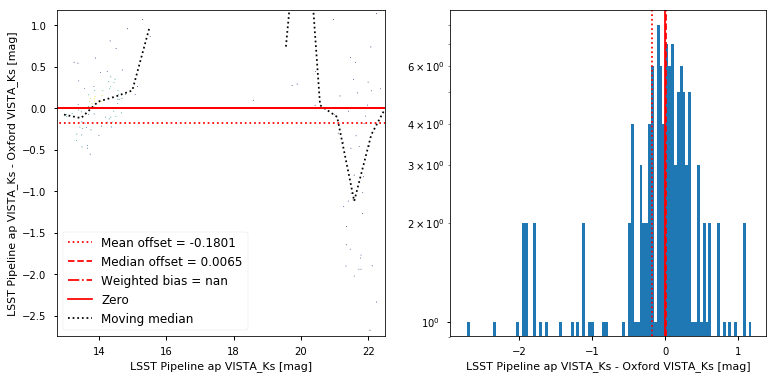

In [65]:

    
def mag_diff(x,xerr,y,yerr, labels,savefig=False,bins = [20,20], sort = True,**kwargs):
    """Plot magnitude offsets for two catalogues"""
    #if 'ap' in labels[0]:
        #print("Comparing {} band AB 2 arc sec aperture magnitudes from {} and {}".format(labels[2],labels[0],labels[1]))
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    #ax3 = plt.subplot(gs2[:, -1], sharey=ax2)
    m = ~np.isnan(x) & ~np.isnan(y)
    x=x[m]
    y=y[m]
    xerr=xerr[m]
    yerr=yerr[m]


    mean_offset = np.nanmean(x - y)
    median_offset = np.nanmedian(x - y)
    print("Mean offset = {}".format(round(mean_offset,4)))
    print("Median offset = {}".format(round(median_offset,4)))
    
    total_var = xerr**2 + yerr**2 #+ 0.03**2 #the extra 0.03 is an estimate of the abs. cal. error for vista
    unsaturated = (x>16) & (x<18) #& m

    weighted_bias = np.nansum(
        (
            x[unsaturated]
            -y[unsaturated]
        )/total_var[unsaturated]
    )/np.nansum(1./total_var[unsaturated])
    print('Weighted bias (16<mag<18) = {}'.format(round(weighted_bias,4)))
    
    
    ax1.plot([0,100],[mean_offset,mean_offset], linestyle='dotted', c='r', alpha=1,
             label = 'Mean offset = {}'.format(round(mean_offset,4)))
    ax1.plot([0,100],[median_offset,median_offset], linestyle='dashed', c='r', alpha=1,
         label = 'Median offset = {}'.format(round(median_offset,4)))
    ax1.plot([0,100],[weighted_bias,weighted_bias], linestyle='dashdot', c='r', alpha=1,
         label = 'Weighted bias = {}'.format(round(weighted_bias,4)))
    ax1.plot([0,100],[0,0], c='r', label='Zero')
    

    n, edges = np.histogram(x, bins=20)
    medians = [np.nanmedian((x-y)[(x>edges[a]) & (x<edges[a+1])]) for a in np.arange(len(n))]
    ax1.plot([np.mean([edges[a], edges[a+1]]) for a in np.arange(len(edges[:-1]))], medians, 
             c='k',linestyle='dotted',label='Moving median')
    
    
    ax1.legend( prop={'size': 12})#, loc='lower left')
    
    x_lims = [np.nanpercentile(x,.1),np.nanpercentile(x,97.5)]
    y_lims= [np.nanpercentile(x-y,2.5),np.nanpercentile(x-y,97.5)]
    in_window = x>x_lims[0] -0.2
    in_window &= x<x_lims[1] +1.
    in_window &= x-y>y_lims[0] 
    in_window &= x-y<y_lims[1]
    x = x[in_window]
    y = y[in_window]
    
    data , x_e, y_e = np.histogram2d( x,  x - y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
                data , np.vstack([x, x - y]).T, method = "splinef2d" , bounds_error = False)#, method = "splinef2d"

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        
    ax1.scatter(x,   x - y, c=z,
            alpha=1., s=0.3, rasterized=True)#,cmap='Greys')
    
    
    ax1.set_xlabel('{} [mag]'.format(labels[0]))
    ax1.plot([0,100],[0,0], c='r')
    
    #upper = np.min([25.,np.nanmax(x),np.nanmax(y)+1] )
    ax1.set_xlim(x_lims)
    ax1.set_ylim(y_lims)
    ax1.set_ylabel('{} - {} [mag]'.format(labels[0],labels[1]))
    
    ax2.hist(x - y,range=y_lims, bins=100)
    ax2.set_yscale('log')
    ax2.set_xlabel('{} - {} [mag]'.format(labels[0],labels[1]))
    ax2.axvline(0, c='r', alpha=1)
    ax2.axvline(mean_offset,linestyle='dotted', c='r', alpha=1)
    ax2.axvline(median_offset,linestyle='dashed', c='r', alpha=1)
    ax2.axvline(weighted_bias,linestyle='dashdot', c='r', alpha=1)
    
    
    #plt.rc('font', family='serif', serif='Times')
    plt.rc('text') #, usetex=True)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', labelsize=14)
    


    if savefig:
        plt.savefig('./figs/mag_compare_{}_{}.pdf'.format(
            labels[0],labels[1]).replace(' ','_'), bbox_inches='tight')
        plt.savefig('./figs/mag_compare_{}_{}.png'.format(
            labels[0],labels[1]).replace(' ','_'), bbox_inches='tight')
    plt.show()
    
f,ferr= mag_to_flux(
    merge['VISTA_Ks_m_base_CircularApertureFlux_6_0_mag'],
    merge['VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr'])
                    
mask = f/ferr > 5
#mask &= merge['HSC_I_m_base_ClassificationExtendedness_value']< 1.

f,ferr= mag_to_flux(
    merge['oxford_ks_m_ap_vista_ks'],
    merge['oxford_ks_merr_ap_vista_ks'])
                    
#mask &= f/ferr > 5
band= 'VISTA_Ks'
print("""Comparing {} band AB 2 arc sec aperture magnitudes from LSST and Oxford. 
LSST circular aperture magnitudes in 2 arcsec radius are not curve of growth corrected.""".format(band))
print('Oxford aperture correction: {}'.format(oxfordApCorr['{}_2as'.format(band)]))
mag_diff(
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
    merge[mask]['oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))] + oxfordApCorr['{}_2as'.format(band)],
    merge[mask]['oxford_ks_merr_ap_{}'.format(band.lower().replace('-','_'))],
    ['LSST Pipeline ap {}'.format(band),'Oxford {}'.format(band), '{}'.format(band)],savefig=True)
    


Comparing VISTA_Ks band AB 2 arc sec aperture magnitudes from LSST and Oxford. 
LSST circular aperture magnitudes in 2 arcsec radius are not curve of growth corrected.
Oxford aperture correction: 0.2288
Mean offset = -0.4179
Median offset = -0.1645
Weighted bias (16<mag<18) = nan


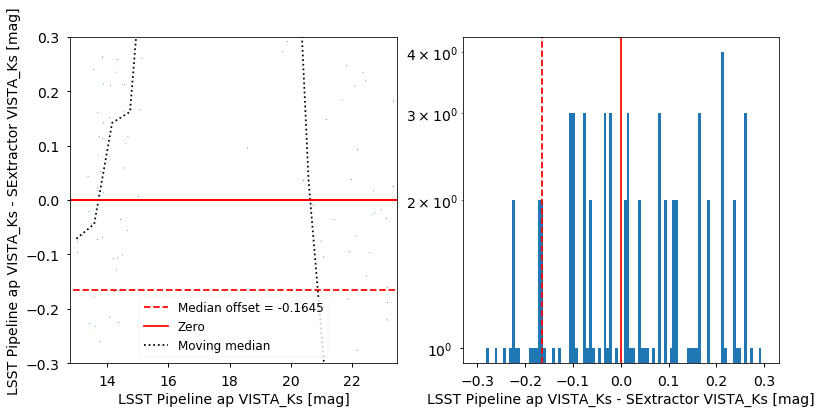

In [76]:

    
def mag_diff2(x,xerr,y,yerr, labels,savefig=False,bins = [20,20], sort = True,**kwargs):
    """Plot magnitude offsets for two catalogues"""
    #if 'ap' in labels[0]:
        #print("Comparing {} band AB 2 arc sec aperture magnitudes from {} and {}".format(labels[2],labels[0],labels[1]))
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    #ax3 = plt.subplot(gs2[:, -1], sharey=ax2)
    m = ~np.isnan(x) & ~np.isnan(y)
    x=x[m]
    y=y[m]
    xerr=xerr[m]
    yerr=yerr[m]


    mean_offset = np.nanmean(x - y)
    median_offset = np.nanmedian(x - y)
    print("Mean offset = {}".format(round(mean_offset,4)))
    print("Median offset = {}".format(round(median_offset,4)))
    
    total_var = xerr**2 + yerr**2 +0.03**2 #the extra 0.03 is an estimate of the abs. cal. error for vista
    unsaturated = (x>16) & (x<18) #& m

    weighted_bias = np.nansum(
        (
            x[unsaturated]
            -y[unsaturated]
        )/total_var[unsaturated]
    )/np.nansum(1./total_var[unsaturated])
    print('Weighted bias (16<mag<18) = {}'.format(round(weighted_bias,4)))
    
    
    #ax1.plot([0,100],[mean_offset,mean_offset], linestyle='dotted', c='r', alpha=1,
    #         label = 'Mean offset = {}'.format(round(mean_offset,4)))
    ax1.plot([0,100],[median_offset,median_offset], linestyle='dashed', c='r', alpha=1,
         label = 'Median offset = {}'.format(round(median_offset,4)))
    #ax1.plot([0,100],[weighted_bias,weighted_bias], linestyle='dashdot', c='r', alpha=1,
    #     label = 'Weighted bias = {}'.format(round(weighted_bias,4)))
    ax1.plot([0,100],[0,0], c='r', label='Zero')
    

    n, edges = np.histogram(x, bins=20)
    medians = [np.nanmedian((x-y)[(x>edges[a]) & (x<edges[a+1])]) for a in np.arange(len(n))]
    ax1.plot([np.mean([edges[a], edges[a+1]]) for a in np.arange(len(edges[:-1]))], medians, 
             c='k',linestyle='dotted',label='Moving median')
    
    
    ax1.legend( prop={'size': 12})#, loc='lower left')
    
    x_lims = [np.nanpercentile(x,.1),np.nanpercentile(x,97.5)]
    y_lims= [np.nanpercentile(x-y,2.5),np.nanpercentile(x-y,97.5)]
    y_lims=[-0.3,0.3]
    in_window = x>x_lims[0] -0.2
    in_window &= x<x_lims[1] +1.
    in_window &= x-y>y_lims[0] 
    in_window &= x-y<y_lims[1]
    x = x[in_window]
    y = y[in_window]
    
    data , x_e, y_e = np.histogram2d( x,  x - y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
                data , np.vstack([x, x - y]).T, method = "splinef2d" , bounds_error = False)#, method = "splinef2d"

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        
    ax1.scatter(x,   x - y, c=z,
            alpha=1., s=0.3, rasterized=True)#,cmap='Greys')
    
    
    ax1.set_xlabel('{} [mag]'.format(labels[0]))
    ax1.plot([0,100],[0,0], c='r')
    
    #upper = np.min([25.,np.nanmax(x),np.nanmax(y)+1] )
    ax1.set_xlim(x_lims)
    ax1.set_ylim(y_lims)
    ax1.set_ylabel('{} - {} [mag]'.format(labels[0],labels[1]))
    
    ax2.hist(x - y,range=y_lims, bins=100)
    ax2.set_yscale('log')
    ax2.set_xlabel('{} - {} [mag]'.format(labels[0],labels[1]))
    ax2.axvline(0, c='r', alpha=1)
    #ax2.axvline(mean_offset,linestyle='dotted', c='r', alpha=1)
    ax2.axvline(median_offset,linestyle='dashed', c='r', alpha=1)
    #ax2.axvline(weighted_bias,linestyle='dashdot', c='r', alpha=1)
    
    
    #plt.rc('font', family='serif', serif='Times')
    plt.rc('text') #, usetex=True)
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', labelsize=14)
    


    if savefig:
        plt.savefig('./figs/mag_compare_{}_{}.pdf'.format(
            labels[0],labels[1]).replace(' ','_'), bbox_inches='tight')
        plt.savefig('./figs/mag_compare_{}_{}.png'.format(
            labels[0],labels[1]).replace(' ','_'), bbox_inches='tight')
    plt.show()
    
f,ferr= mag_to_flux(
    merge['VISTA_Ks_m_base_CircularApertureFlux_6_0_mag'],
    merge['VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr'])
                    
mask = f/ferr > 1
#mask &= merge['HSC-I_m_base_ClassificationExtendedness_value']< 1.

f,ferr= mag_to_flux(
    merge['oxford_ks_m_ap_vista_ks'],
    merge['oxford_ks_merr_ap_vista_ks'])
                    
#mask &= f/ferr > 5
band= 'VISTA_Ks'
print("""Comparing {} band AB 2 arc sec aperture magnitudes from LSST and Oxford. 
LSST circular aperture magnitudes in 2 arcsec radius are not curve of growth corrected.""".format(band))
print('Oxford aperture correction: {}'.format(oxfordApCorr['{}_2as'.format(band)]))
mag_diff2(
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
    merge[mask]['oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))] + oxfordApCorr['{}_2as'.format(band)],
    merge[mask]['oxford_ks_merr_ap_{}'.format(band.lower().replace('-','_'))],
    ['LSST Pipeline ap {}'.format(band),'SExtractor {}'.format(band), '{}'.format(band)],savefig=True)
    


Mean offset = -0.2919
Median offset = -0.0202
Weighted bias (16<mag<18) = nan


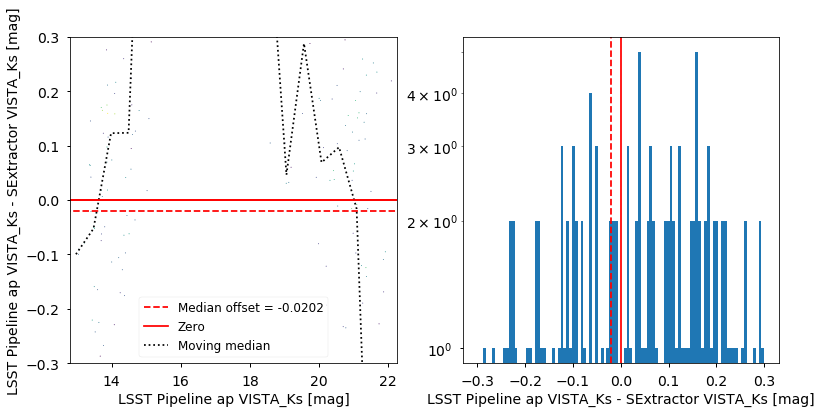

In [67]:
mag_diff2(
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
    merge[mask]['help_m_ap_{}'.format(band.lower().replace('-','_'))] ,
    merge[mask]['help_merr_ap_{}'.format(band.lower().replace('-','_'))],
    ['LSST Pipeline ap {}'.format(band),'SExtractor {}'.format(band), '{}'.format(band)],savefig=True)

Mean offset = -1.0869
Median offset = 0.0126
Weighted bias (16<mag<18) = -1.8894


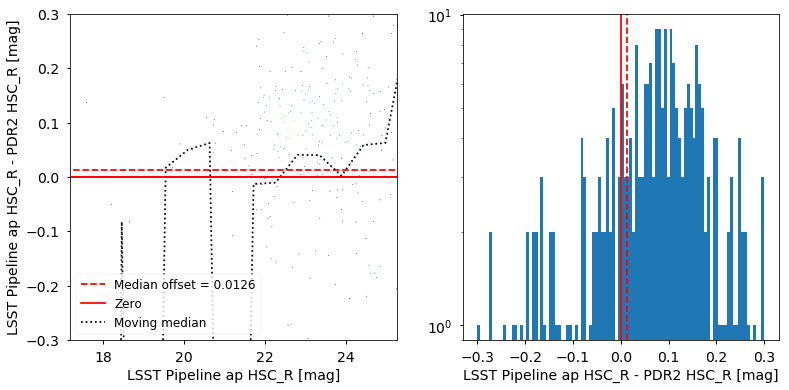

In [68]:
band='HSC_R'
mag_diff2(
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
    merge[mask]['hsc_m_ap_{}'.format(band.lower().replace('-','_'))] ,
    merge[mask]['hsc_merr_ap_{}'.format(band.lower().replace('-','_'))],
    ['LSST Pipeline ap {}'.format(band),'PDR2 {}'.format(band), '{}'.format(band)],savefig=True)

Mean offset = -0.536
Median offset = -0.3219
Weighted bias (16<mag<18) = nan


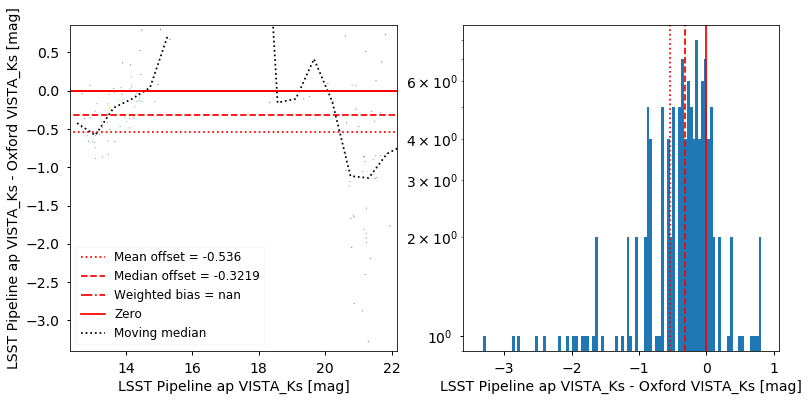

In [69]:
band= 'VISTA_Ks'
mag_diff(
    merge[mask]['{}_m_base_CircularApertureFlux_12_0_mag'.format(band)],
    merge[mask]['{}_m_base_CircularApertureFlux_12_0_magErr'.format(band)],
    merge[mask]['oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))] + oxfordApCorr['{}_2as'.format(band)],
    merge[mask]['oxford_ks_merr_ap_{}'.format(band.lower().replace('-','_'))],
    ['LSST Pipeline ap {}'.format(band),'Oxford {}'.format(band), '{}'.format(band)],savefig=True)
#plt.savefig('./figs/Ks_mag_diffs_6pix_2as.pdf', bbox_inches='tight')

Mean offset = -0.2919
Median offset = -0.0202
Weighted bias (16<mag<18) = nan


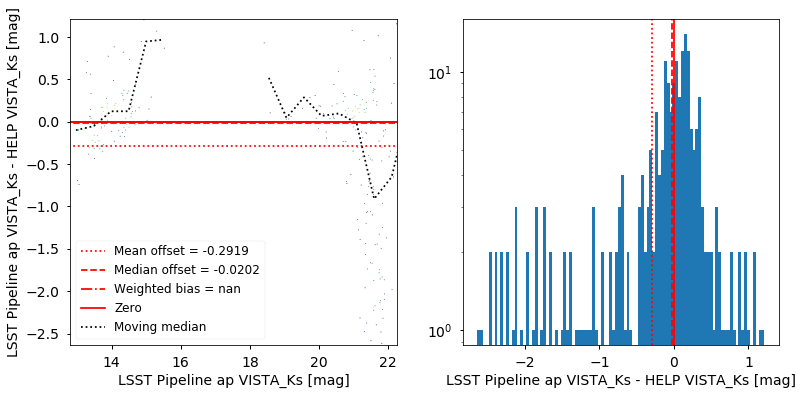

In [70]:
band= 'VISTA_Ks'
mag_diff(
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
    merge[mask]['help_m_ap_{}'.format(band.lower().replace('-','_'))] ,
    merge[mask]['help_merr_ap_{}'.format(band.lower().replace('-','_'))],
    ['LSST Pipeline ap {}'.format(band),'HELP {}'.format(band), '{}'.format(band)],savefig=True)

Mean offset = -1.0869
Median offset = 0.0126
Weighted bias (16<mag<18) = -0.0678


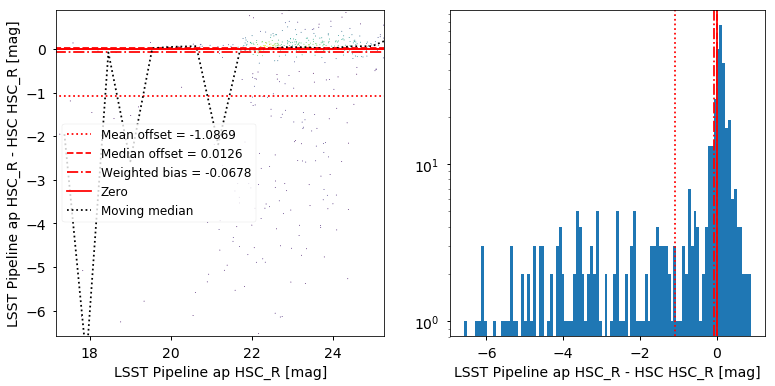

In [71]:
band='HSC_R'
mag_diff(
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
    merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
    merge[mask]['hsc_m_ap_{}'.format(band.lower().replace('-','_'))] ,
    merge[mask]['hsc_merr_ap_{}'.format(band.lower().replace('-','_'))],
    ['LSST Pipeline ap {}'.format(band),'HSC {}'.format(band), '{}'.format(band)],savefig=True)

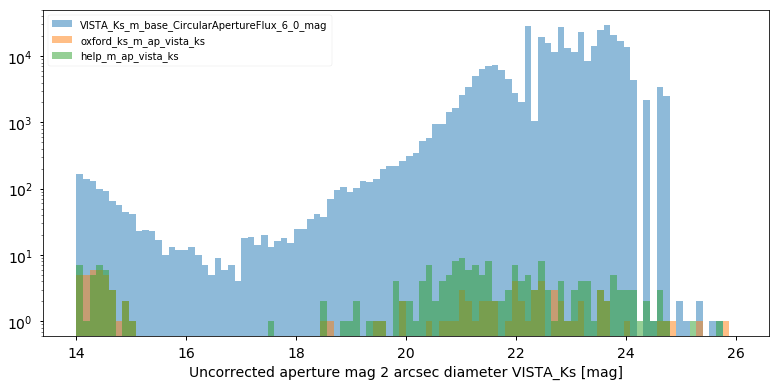

In [72]:
fig, ax = plt.subplots(figsize=(13, 6))
band='VISTA_Ks'
xName1='{}_m_base_CircularApertureFlux_6_0_mag'.format(band)
xName2='oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))
xName3='help_m_ap_{}'.format(band.lower().replace('-','_'))
ax.hist(merge[mask][xName1], 
        range=[14,26],bins=100,alpha=0.5,label=xName1)
ax.hist((merge[mask][xName2] 
         + oxfordApCorr['{}_2as'.format(band)]
        ), range=[14,26],bins=100,alpha=0.5,label=xName2)
ax.hist((merge[mask][xName3] 
         
        ), range=[14,26],bins=100,alpha=0.5,label=xName3)
ax.set_yscale('log')
ax.set_xlabel('Uncorrected aperture mag 2 arcsec diameter {} [mag]'.format(band))
ax.legend()

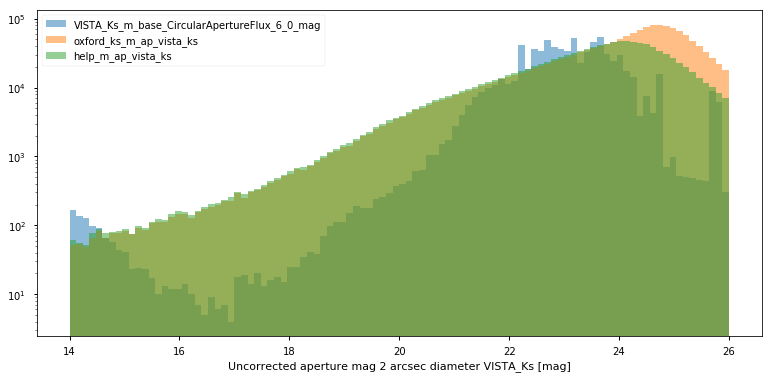

In [114]:
fig, ax = plt.subplots(figsize=(13, 6))
band='VISTA_Ks'
xName1='{}_m_base_CircularApertureFlux_6_0_mag'.format(band)
xName2='oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))
xName3='help_m_ap_{}'.format(band.lower().replace('-','_'))
ax.hist(merge[xName1], 
        range=[14,26],bins=100,alpha=0.5,label=xName1)
ax.hist((merge[xName2] 
         + oxfordApCorr['{}_2as'.format(band)]
        ), range=[14,26],bins=100,alpha=0.5,label=xName2)
ax.hist((merge[xName3] 
         
        ), range=[14,26],bins=100,alpha=0.5,label=xName3)
ax.set_yscale('log')
ax.set_xlabel('Uncorrected aperture mag 2 arcsec diameter {} [mag]'.format(band))
ax.legend()

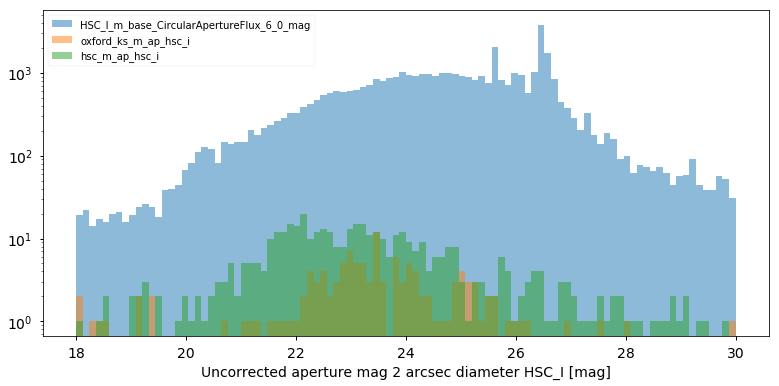

In [73]:
fig, ax = plt.subplots(figsize=(13, 6))
band='HSC_I'
xName1='{}_m_base_CircularApertureFlux_6_0_mag'.format(band)
xName2='oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))
xName3='hsc_m_ap_{}'.format(band.lower().replace('-','_'))
ax.hist(merge[mask][xName1], 
        range=[18,30],bins=100,alpha=0.5,label=xName1)
ax.hist((merge[mask][xName2] 
         + oxfordApCorr['{}_2as'.format(band)]
        ), range=[18,30],bins=100,alpha=0.5,label=xName2)
ax.hist((merge[mask][xName3] 
         
        ), range=[18,30],bins=100,alpha=0.5,label=xName3)
ax.set_yscale('log')
ax.set_xlabel('Uncorrected aperture mag 2 arcsec diameter {} [mag]'.format(band))
ax.legend()

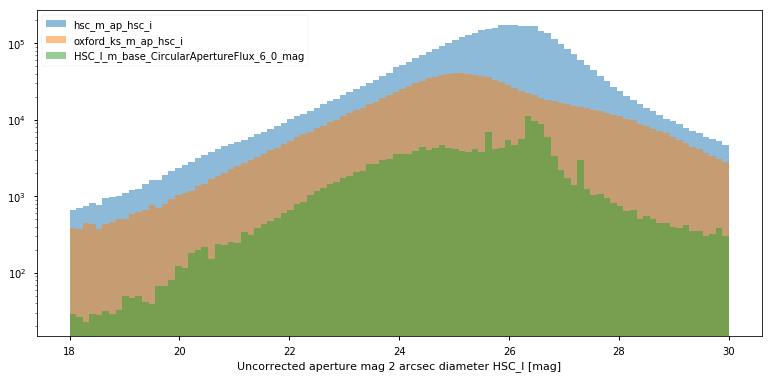

In [117]:
fig, ax = plt.subplots(figsize=(13, 6))
band='HSC_I'
xName1='{}_m_base_CircularApertureFlux_6_0_mag'.format(band)
xName2='oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))
xName3='hsc_m_ap_{}'.format(band.lower().replace('-','_'))


ax.hist((merge[xName3] 
         
        ), range=[18,30],bins=100,alpha=0.5,label=xName3)
ax.hist((merge[xName2] 
         + oxfordApCorr['{}_2as'.format(band)]
        ), range=[18,30],bins=100,alpha=0.5,label=xName2)
ax.hist(merge[xName1], 
        range=[18,30],bins=100,alpha=0.5,label=xName1)
ax.set_yscale('log')
ax.set_xlabel('Uncorrected aperture mag 2 arcsec diameter {} [mag]'.format(band))
ax.legend()

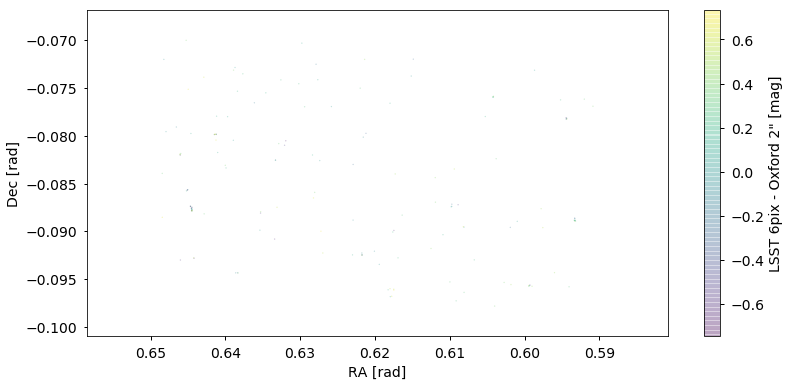

In [74]:
fig, ax = plt.subplots(figsize=(13, 6))
apDiff = merge['VISTA_Ks_m_base_CircularApertureFlux_6_0_mag'] - merge['oxford_ks_m_ap_vista_ks']
m = apDiff > -0.75
m &= apDiff < 0.75
im = ax.scatter(merge[m]['VISTA_Ks_m_coord_ra'],merge[m]['VISTA_Ks_m_coord_dec'],c=apDiff[m],
                s=1.1,alpha=0.2, rasterized=True)
fig.colorbar(im, ax=ax).set_label('LSST 6pix - Oxford 2" [mag]')
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.max(merge[m]['VISTA_Ks_m_coord_ra'])+0.01, np.min(merge[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/apDiff_6-Oxford_VISTA-Ks.pdf', bbox_inches='tight')
fig.savefig('./figs/apDiff_6-Oxford_VISTA-Ks.png', bbox_inches='tight')

HSC_G_m_base_CircularApertureFlux_6_0_mag
Comparing HSC_G band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = -0.9905
Median offset = -0.6518
Weighted bias (16<mag<18) = -3.8717


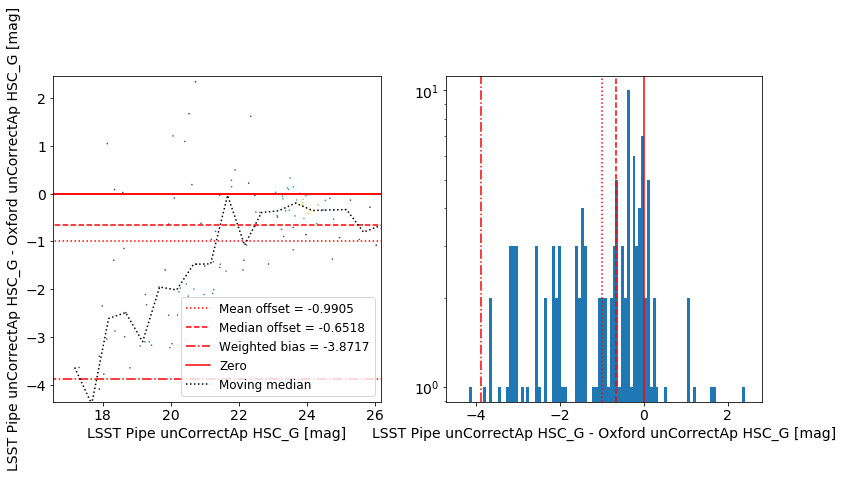

Comparing HSC_G band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -0.6974
Median offset = -0.4403
Weighted bias (16<mag<18) = -3.225


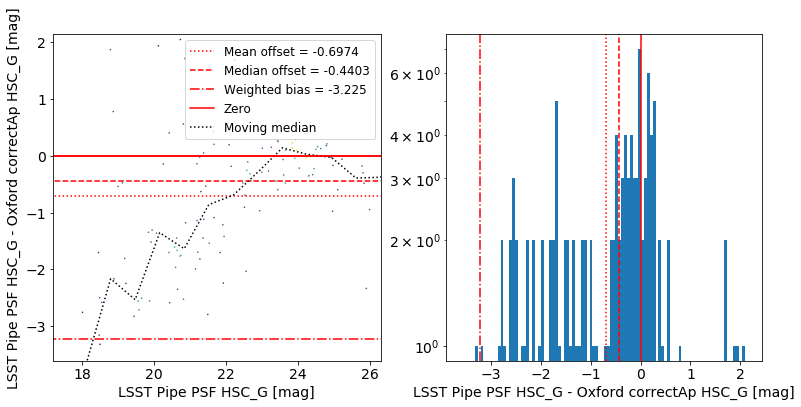

HSC_R_m_base_CircularApertureFlux_6_0_mag
Comparing HSC_R band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = -0.4211
Median offset = -0.2422
Weighted bias (16<mag<18) = -4.2776


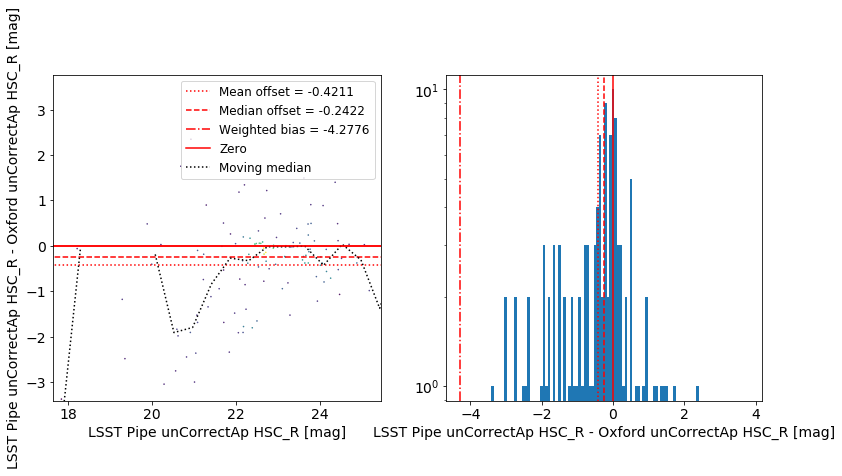

Comparing HSC_R band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -0.639
Median offset = -0.3082
Weighted bias (16<mag<18) = -3.0043


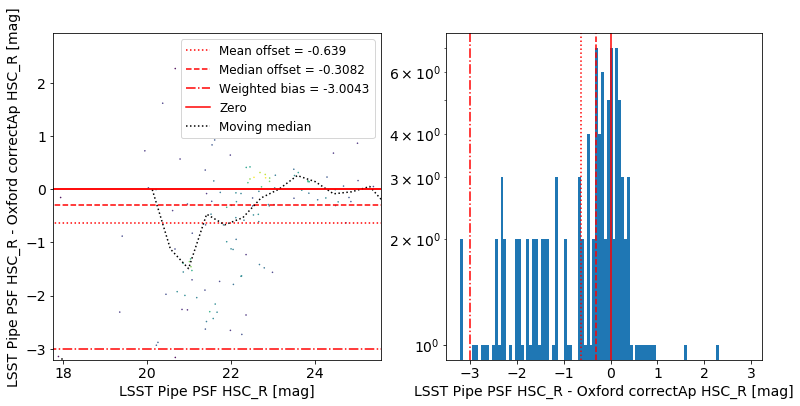

HSC_I_m_base_CircularApertureFlux_6_0_mag
Comparing HSC_I band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = -0.6435
Median offset = -0.419
Weighted bias (16<mag<18) = -0.1178


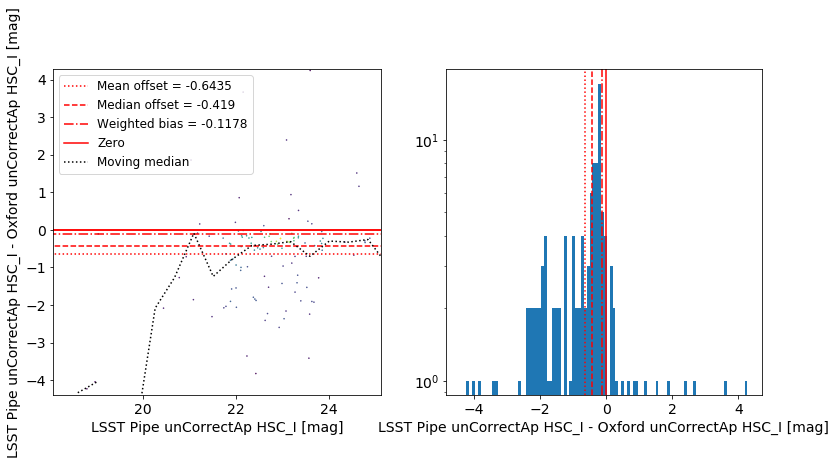

Comparing HSC_I band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = 0.1708
Median offset = 0.1624
Weighted bias (16<mag<18) = -0.0672


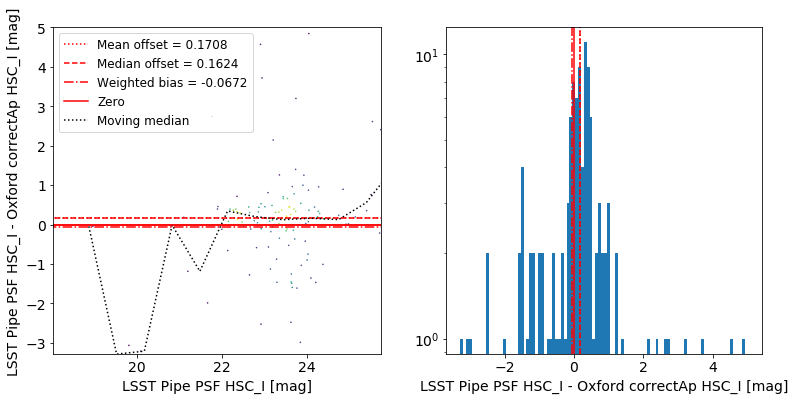

HSC_Z_m_base_CircularApertureFlux_6_0_mag
Comparing HSC_Z band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = -0.2651
Median offset = -0.2344
Weighted bias (16<mag<18) = -2.6728


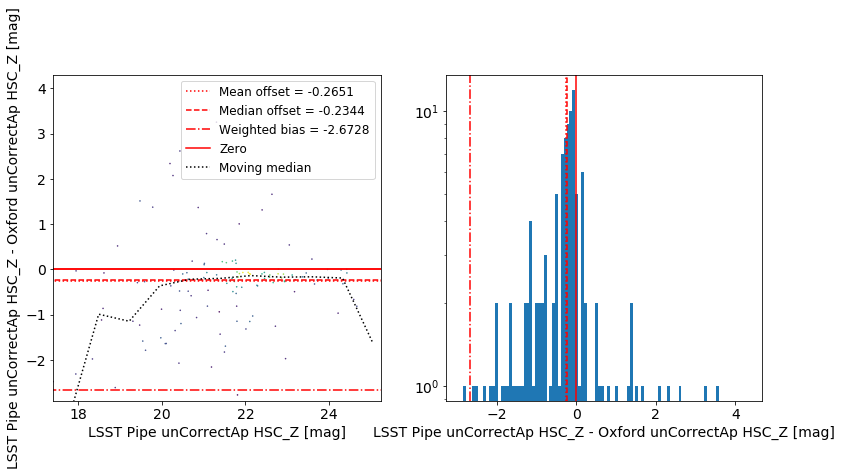

Comparing HSC_Z band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = 0.3608
Median offset = 0.2441
Weighted bias (16<mag<18) = -1.8749


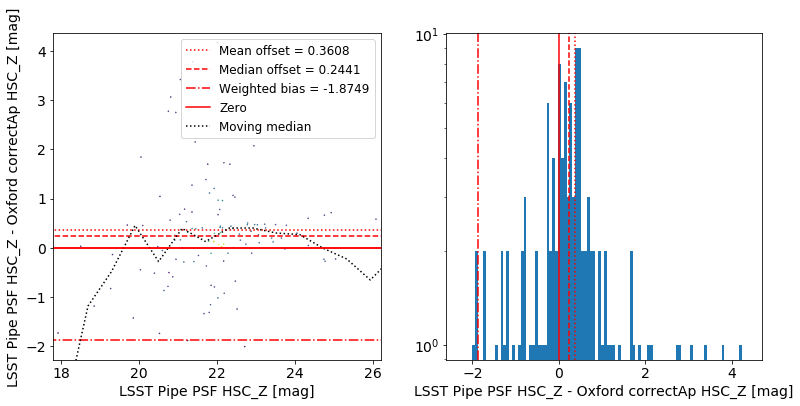

HSC_Y_m_base_CircularApertureFlux_6_0_mag
Comparing HSC_Y band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = -0.5122
Median offset = -0.3984
Weighted bias (16<mag<18) = -1.9794


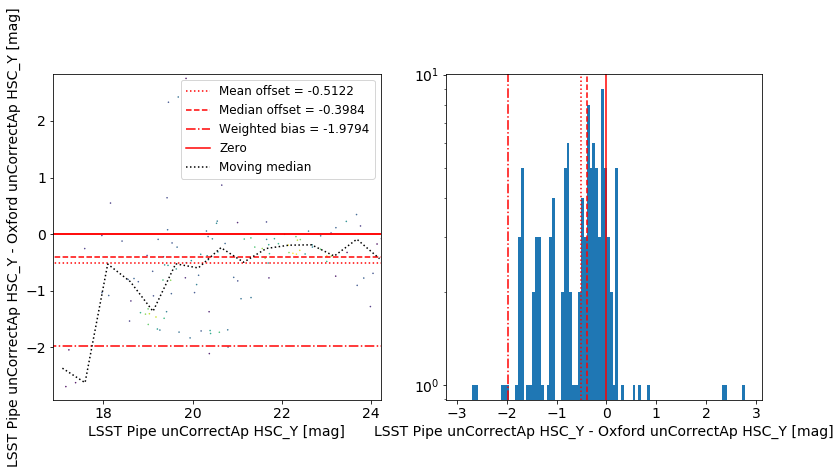

Comparing HSC_Y band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = 0.3427
Median offset = 0.2221
Weighted bias (16<mag<18) = -1.568


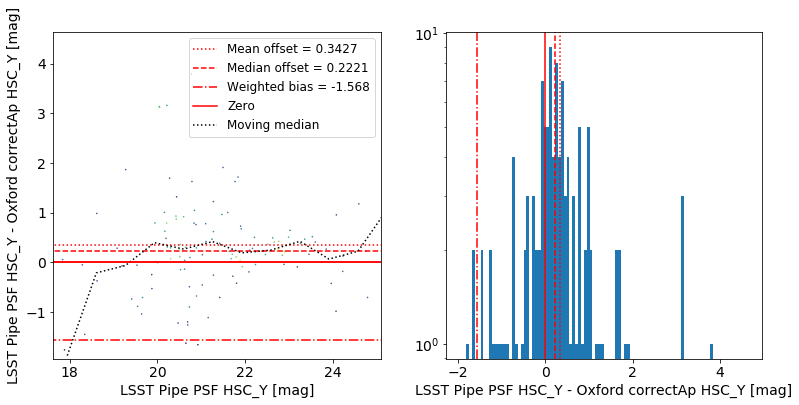

VISTA_J_m_base_CircularApertureFlux_6_0_mag
Comparing VISTA_J band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = -0.0542
Median offset = -0.2895
Weighted bias (16<mag<18) = nan


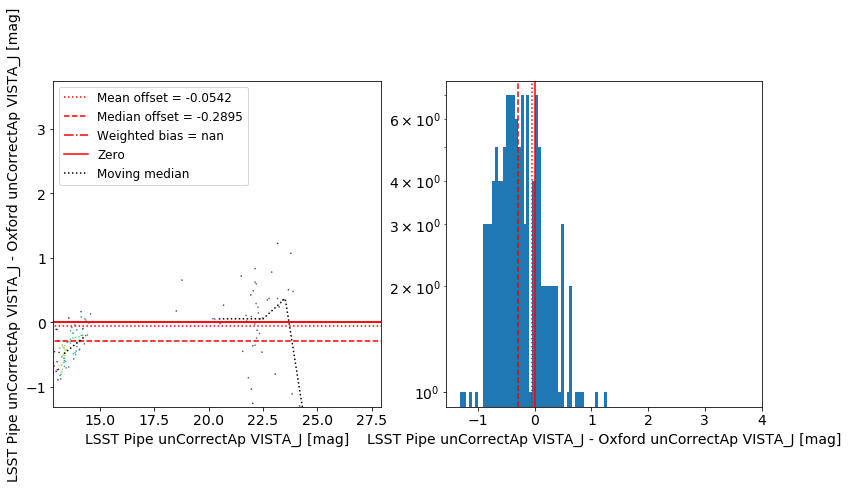

Comparing VISTA_J band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -0.2258
Median offset = -0.2793
Weighted bias (16<mag<18) = nan


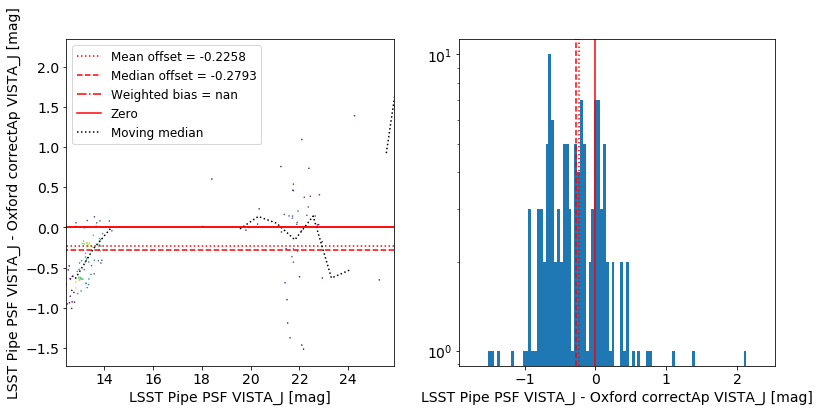

VISTA_H_m_base_CircularApertureFlux_6_0_mag
Comparing VISTA_H band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = 0.3929
Median offset = 0.1108
Weighted bias (16<mag<18) = nan


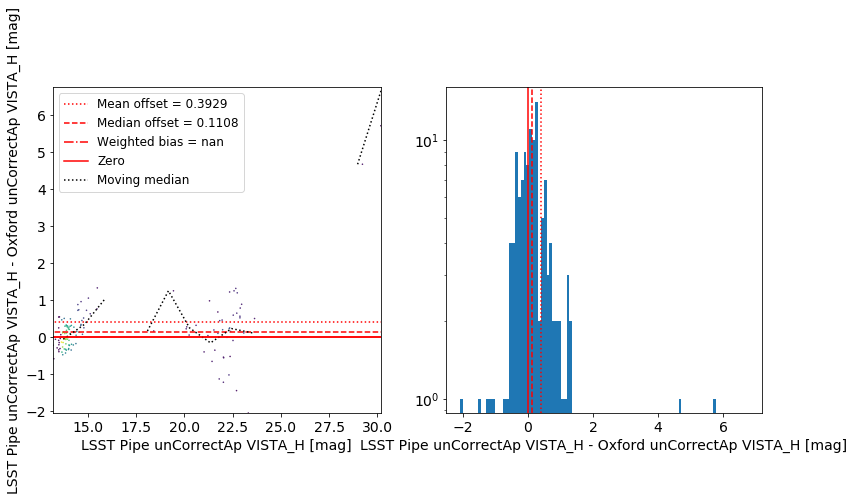

Comparing VISTA_H band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = 0.2759
Median offset = 0.1243
Weighted bias (16<mag<18) = -0.0287


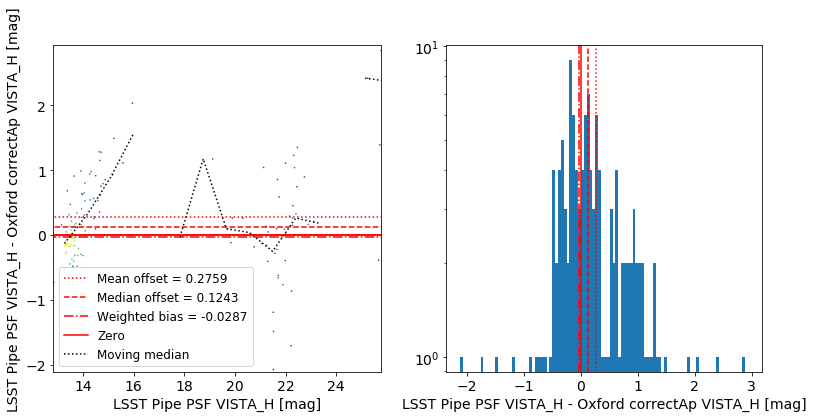

VISTA_Ks_m_base_CircularApertureFlux_6_0_mag
Comparing VISTA_Ks band AB 2 arcsec radius aperture magnitudes from LSST and Oxford
Oxford ap corr: {}
Mean offset = -0.1801
Median offset = 0.0065
Weighted bias (16<mag<18) = nan


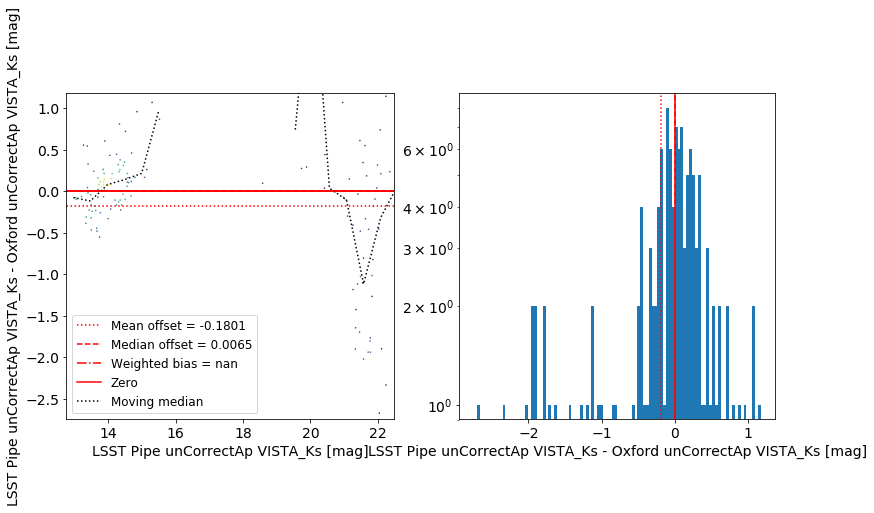

Comparing VISTA_Ks band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -0.1606
Median offset = 0.0004
Weighted bias (16<mag<18) = nan


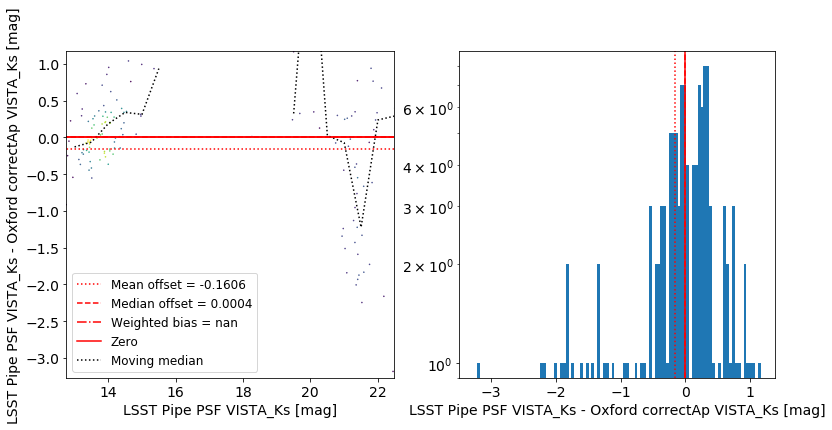

In [54]:
for col in merge.colnames:
    if col.endswith('6_0_mag'):
        print(col)
        band = '{}_{}'.format(col.split('_')[0],col.split('_')[1])
        print("Comparing {} band AB 2 arcsec radius aperture magnitudes from LSST and Oxford".format(band))
        print("Oxford ap corr: {}")
        try:
            mag_diff(
                merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
                merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
                (merge[mask]['oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))] 
                 + oxfordApCorr['{}_2as'.format(band)]),
                merge[mask]['oxford_ks_merr_ap_{}'.format(band.lower().replace('-','_'))],
                ['LSST Pipe unCorrectAp {}'.format(band),'Oxford unCorrectAp {}'.format(band), '{}'.format(band)]
            ,savefig=False)
            print("Comparing {} band magnitudes from LSST PSF and Oxford 2 arcsec corrected  ".format(band))
            mag_diff(
                merge[mask]['{}_m_base_PsfFlux_mag'.format(band)],
                merge[mask]['{}_m_base_PsfFlux_magErr'.format(band)],
                merge[mask]['oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))],
                merge[mask]['oxford_ks_merr_ap_{}'.format(band.lower().replace('-','_'))],
                ['LSST Pipe PSF {}'.format(band),'Oxford correctAp {}'.format(band), '{}'.format(band)])
        except:
            print('Failed')

hsc_m_ap_hsc_g
Comparing HSC_G band AB 2 arcsec radius aperture magnitudes from LSST and HSC
Mean offset = -1.1049
Median offset = -0.0295
Weighted bias (16<mag<18) = -0.7167


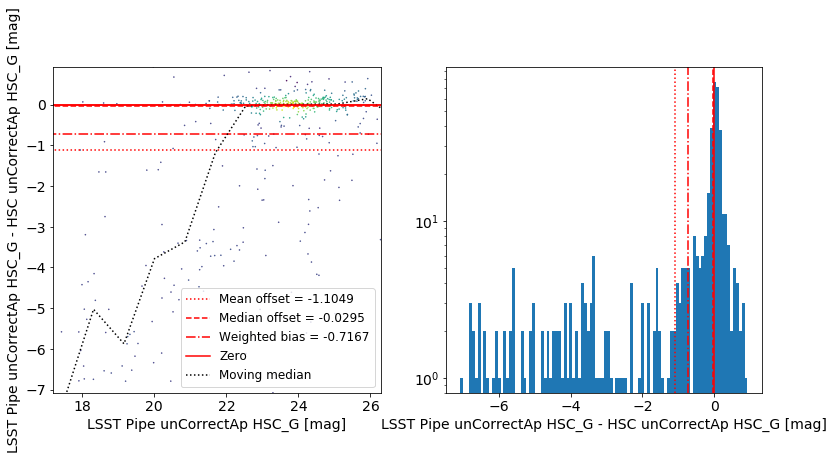

Comparing HSC_G band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -0.9631
Median offset = 0.0554
Weighted bias (16<mag<18) = -0.1034


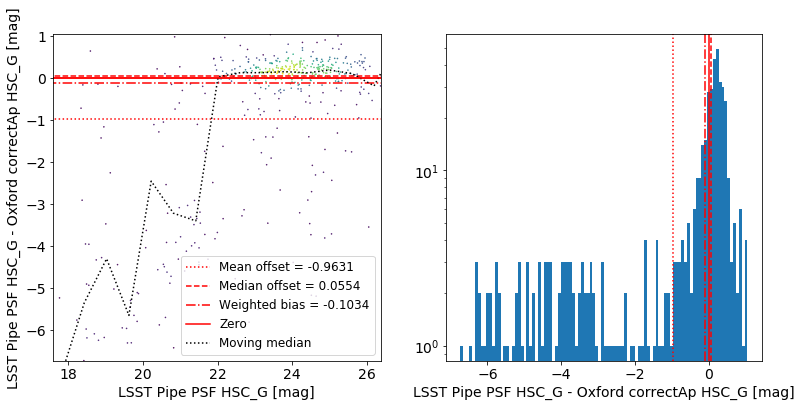

hsc_m_ap_hsc_r
Comparing HSC_R band AB 2 arcsec radius aperture magnitudes from LSST and HSC
Mean offset = -1.0869
Median offset = 0.0126
Weighted bias (16<mag<18) = -0.0678


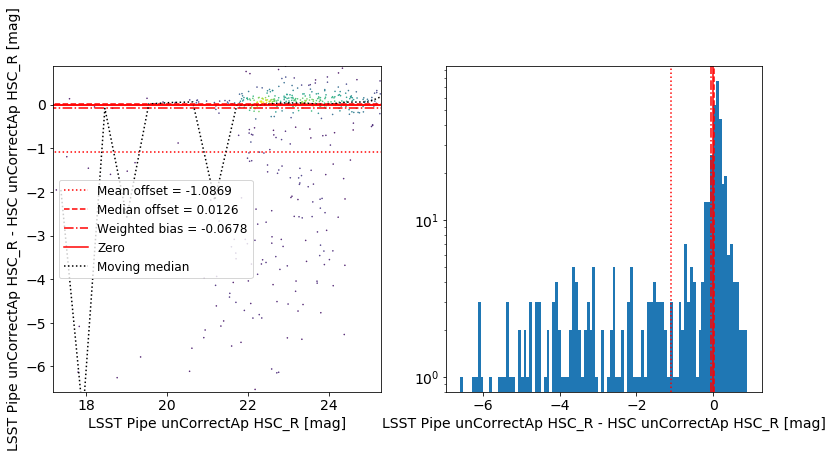

Comparing HSC_R band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -1.1138
Median offset = -0.0015
Weighted bias (16<mag<18) = -0.0911


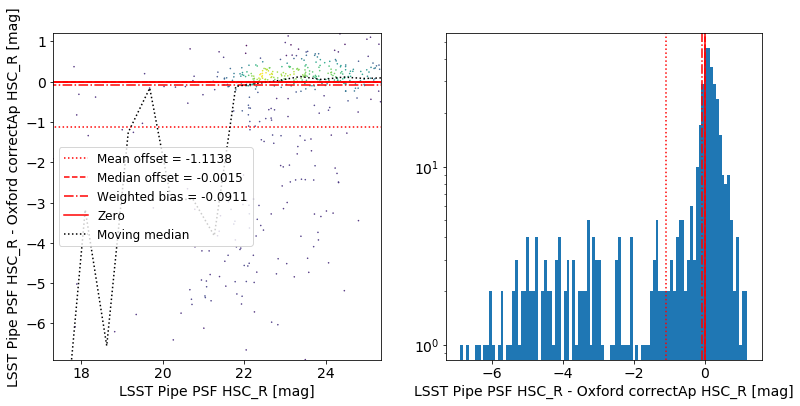

hsc_m_ap_hsc_i
Comparing HSC_I band AB 2 arcsec radius aperture magnitudes from LSST and HSC
Mean offset = -2.068
Median offset = -0.12
Weighted bias (16<mag<18) = 0.0303


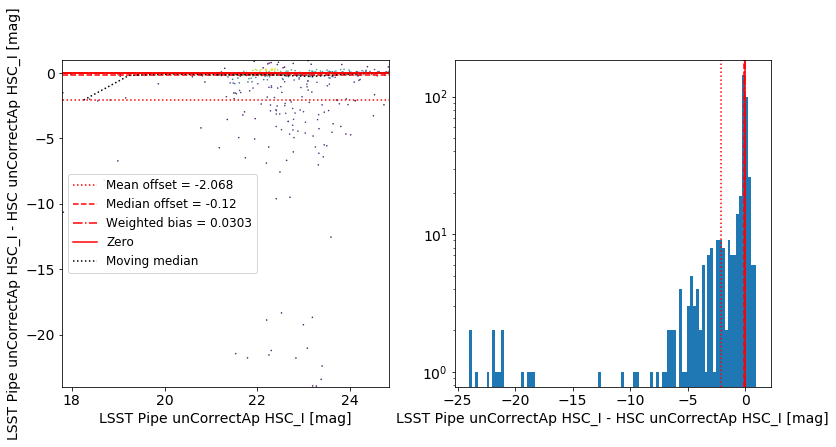

Comparing HSC_I band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -1.4561
Median offset = 0.2113
Weighted bias (16<mag<18) = -0.2028


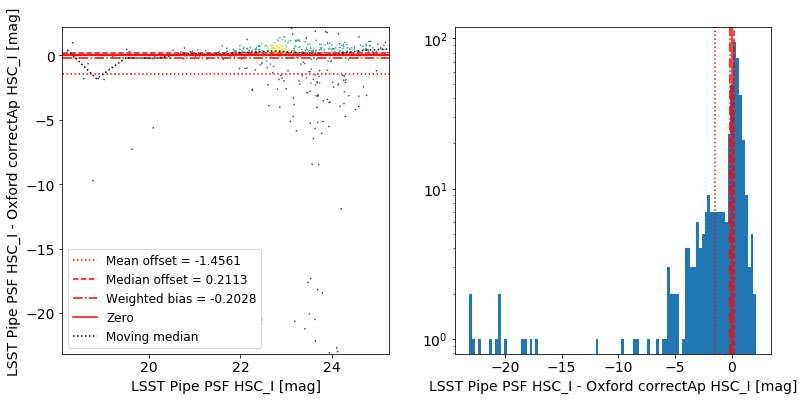

hsc_m_ap_hsc_z
Comparing HSC_Z band AB 2 arcsec radius aperture magnitudes from LSST and HSC
Mean offset = -0.9608
Median offset = -0.0401
Weighted bias (16<mag<18) = -0.1072


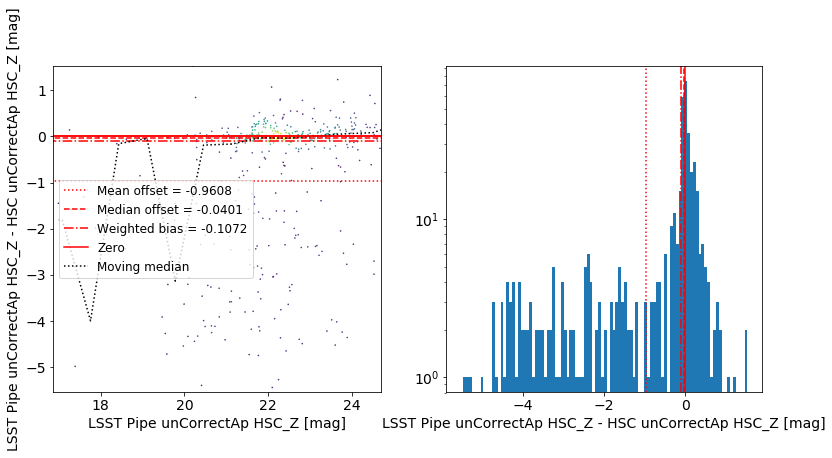

Comparing HSC_Z band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -0.6257
Median offset = 0.114
Weighted bias (16<mag<18) = 0.1493


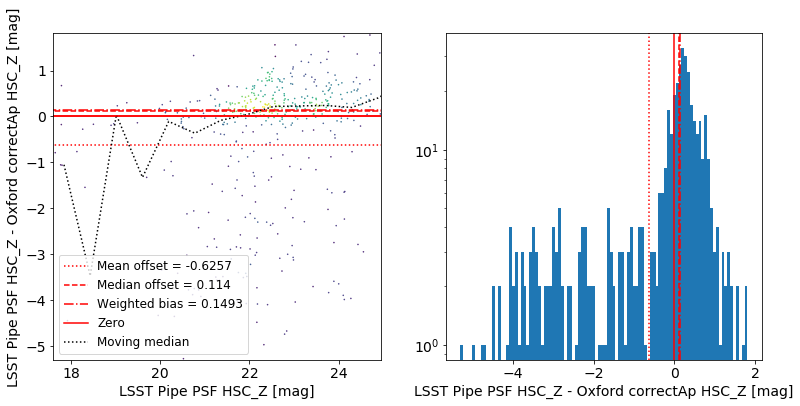

hsc_m_ap_hsc_y
Comparing HSC_Y band AB 2 arcsec radius aperture magnitudes from LSST and HSC
Mean offset = -0.9659
Median offset = -0.0954
Weighted bias (16<mag<18) = -0.2114


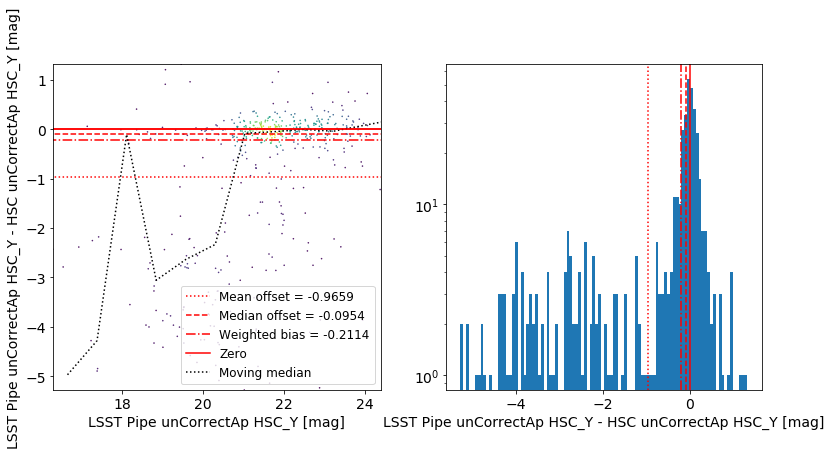

Comparing HSC_Y band magnitudes from LSST PSF and Oxford 2 arcsec corrected  
Mean offset = -0.453
Median offset = 0.1386
Weighted bias (16<mag<18) = 0.194


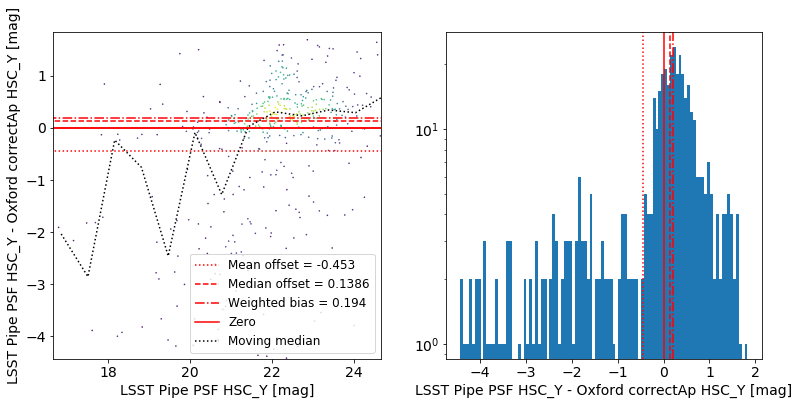

In [55]:
for col in merge.colnames:
    if col.startswith('hsc_m_'):
        print(col)
        band = 'HSC_'+col.split('_')[-1].upper()
        print("Comparing {} band AB 2 arcsec radius aperture magnitudes from LSST and HSC".format(band))
     
        try:
            mag_diff(
                merge[mask]['{}_m_base_CircularApertureFlux_6_0_mag'.format(band)],
                merge[mask]['{}_m_base_CircularApertureFlux_6_0_magErr'.format(band)],
                (merge[mask]['hsc_m_ap_{}'.format(band.lower().replace('-','_'))] 
                 ),
                merge[mask]['hsc_merr_ap_{}'.format(band.lower().replace('-','_'))],
                ['LSST Pipe unCorrectAp {}'.format(band),'HSC unCorrectAp {}'.format(band), '{}'.format(band)]
            ,savefig=False)
            print("Comparing {} band magnitudes from LSST PSF and Oxford 2 arcsec corrected  ".format(band))
            mag_diff(
                merge[mask]['{}_m_base_PsfFlux_mag'.format(band)],
                merge[mask]['{}_m_base_PsfFlux_magErr'.format(band)],
                merge[mask]['hsc_m_ap_{}'.format(band.lower().replace('-','_'))],
                merge[mask]['hsc_merr_ap_{}'.format(band.lower().replace('-','_'))],
                ['LSST Pipe PSF {}'.format(band),'Oxford correctAp {}'.format(band), '{}'.format(band)])
        except:
            print('Failed')

LSST aperture uncorrected


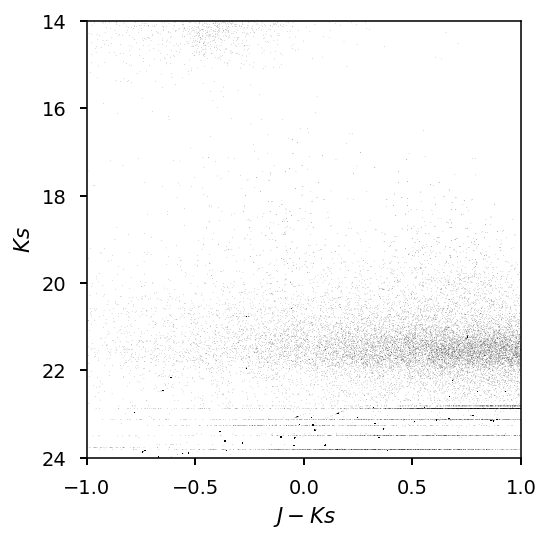

In [56]:
print('LSST aperture uncorrected')
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter((merge[mask]['VISTA_J_m_base_CircularApertureFlux_6_0_mag'] 
             - merge[mask]['VISTA_Ks_m_base_CircularApertureFlux_6_0_mag']),
            merge[mask]['VISTA_Ks_m_base_CircularApertureFlux_6_0_mag'],
            edgecolors='None', s=0.05,c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(24, 14)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

Oxford aperture corrected


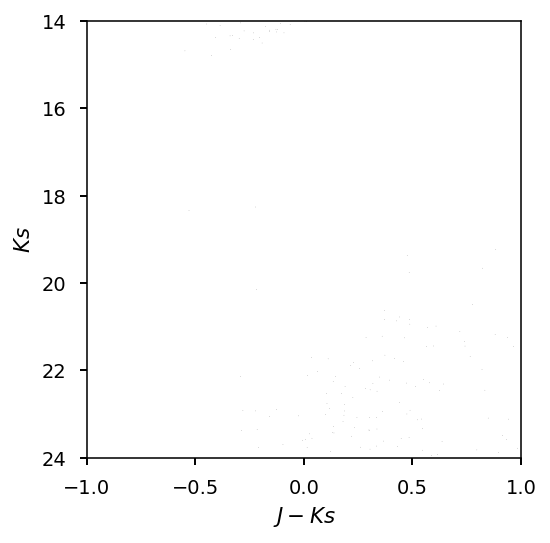

In [77]:
print('Oxford aperture corrected')
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter((merge[mask]['oxford_ks_m_ap_vista_j'] 
             - merge[mask]['oxford_ks_m_ap_vista_ks']),
            merge[mask]['oxford_ks_m_ap_vista_ks'],
            edgecolors='None', s=0.05,c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(24, 14)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

LSST PSF


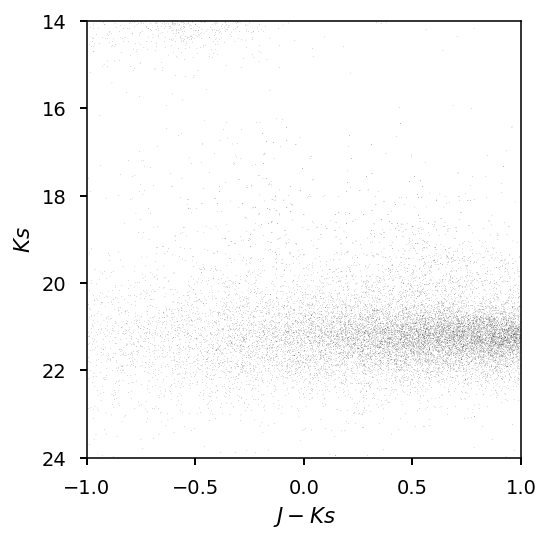

In [58]:
print('LSST PSF')
plt.style.use('seaborn-notebook')
plt.figure(1, figsize=(4, 4), dpi=140)
plt.scatter((merge[mask]['VISTA_J_m_base_PsfFlux_mag'] 
             - merge[mask]['VISTA_Ks_m_base_PsfFlux_mag']),
            merge[mask]['VISTA_Ks_m_base_PsfFlux_mag'],
            edgecolors='None', s=0.05,c='k', rasterized=True)
plt.xlim(-1, 1)
plt.ylim(24, 14)
plt.xlabel('$J-Ks$')
plt.ylabel('$Ks$')
plt.subplots_adjust(left=0.125, bottom=0.1)
plt.show()

## Comparing errors

Now we will plot similar offsets for the measured errors. 

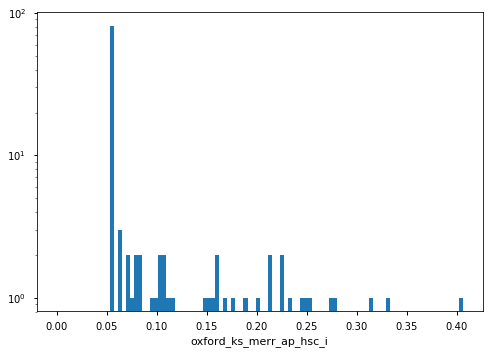

In [59]:
plt.hist(merge[mask]['oxford_ks_merr_ap_hsc_i'],
         range=[0,
                np.nanpercentile(merge[mask]['oxford_ks_merr_ap_hsc_i'],95)], 
         bins=100)
plt.xlabel('oxford_ks_merr_ap_hsc_i')
plt.yscale('log')

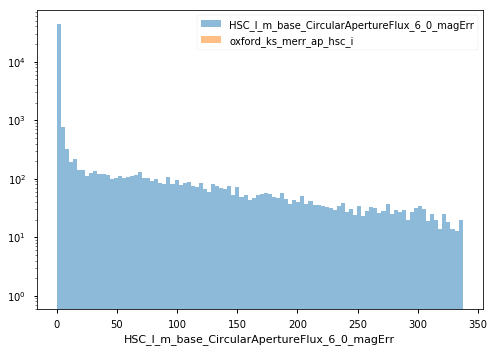

In [60]:
plt.hist(merge[mask]['HSC_I_m_base_CircularApertureFlux_6_0_magErr'],
         range=[0,
                np.nanpercentile(merge[mask]['HSC_I_m_base_CircularApertureFlux_6_0_magErr'],95)], 
         bins=100,alpha=0.5,label='HSC_I_m_base_CircularApertureFlux_6_0_magErr')
plt.hist(merge[mask]['oxford_ks_merr_ap_hsc_i'],
         range=[0,
                np.nanpercentile(merge[mask]['oxford_ks_merr_ap_hsc_i'],95)], 
         bins=100, alpha=0.5,label='oxford_ks_merr_ap_hsc_i')
plt.legend()
plt.xlabel('HSC_I_m_base_CircularApertureFlux_6_0_magErr')
plt.yscale('log')

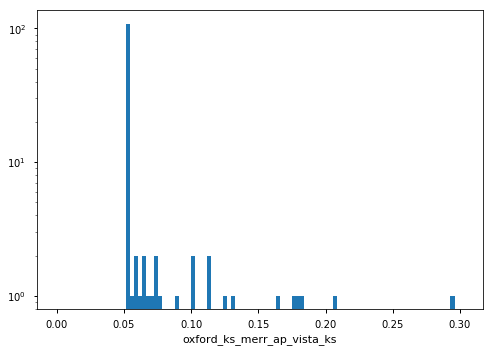

In [61]:
plt.hist(merge[mask]['oxford_ks_merr_ap_vista_ks'],
         range=[0,
                np.nanpercentile(merge[mask]['oxford_ks_merr_ap_vista_ks'],95)], 
         bins=100)
plt.xlabel('oxford_ks_merr_ap_vista_ks')
plt.yscale('log')

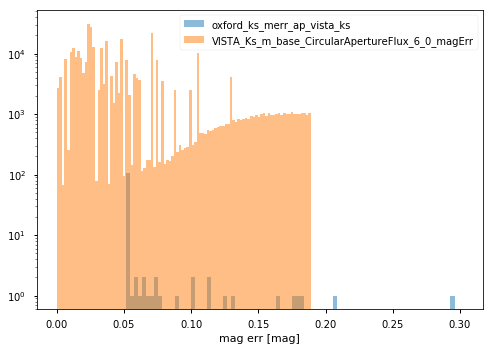

In [62]:
plt.hist(merge[mask]['oxford_ks_merr_ap_vista_ks'],
         range=[0,
                np.nanpercentile(merge[mask]['oxford_ks_merr_ap_vista_ks'],95)], 
         bins=100,alpha=0.5,label='oxford_ks_merr_ap_vista_ks')
plt.hist(merge[mask]['VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr'],
         range=[0,
                np.nanpercentile(merge[mask]['VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr'],95)], 
         bins=100,alpha=0.5,label='VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr')
plt.legend()
plt.xlabel('mag err [mag]')
plt.yscale('log')

In [63]:
0.339/0.168

2.017857142857143

Text(0, 0.5, 'oxford_ks_merr_ap_vista_j')

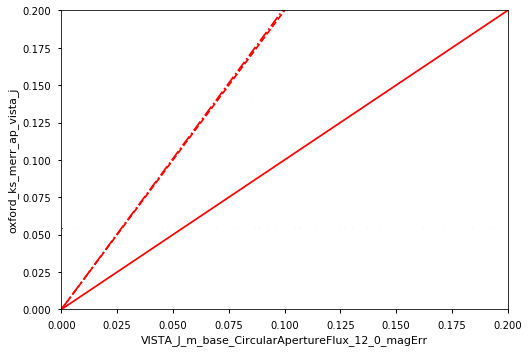

In [78]:
xName = 'VISTA_J_m_base_CircularApertureFlux_12_0_magErr'
yName = 'oxford_ks_merr_ap_vista_j'
plt.scatter(
    merge[mask][xName],
    merge[mask][yName],
    s=0.1,
    alpha=0.2,rasterized=True)
plt.plot([0,1],[0,1], c='r')
plt.plot([0,1],[0,2], c='r', linestyle='--')
plt.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
plt.xlim([0,0.2])
plt.ylim([0,0.2])
plt.xlabel(xName)
plt.ylabel(yName)

Text(0, 0.5, 'oxford_ks_merr_ap_vista_h')

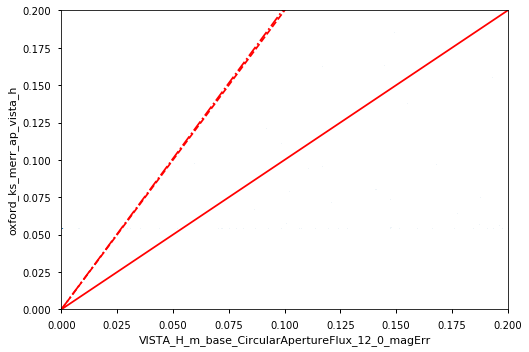

In [79]:
xName = 'VISTA_H_m_base_CircularApertureFlux_12_0_magErr'
yName = 'oxford_ks_merr_ap_vista_h'
plt.scatter(
    merge[mask][xName],
    merge[mask][yName],
    s=0.1,
    alpha=0.2,rasterized=True)
plt.plot([0,1],[0,1], c='r')
plt.plot([0,1],[0,2], c='r', linestyle='--')
plt.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
plt.xlim([0,0.2])
plt.ylim([0,0.2])
plt.xlabel(xName)
plt.ylabel(yName)

Text(0, 0.5, 'oxford_ks_merr_ap_vista_ks')

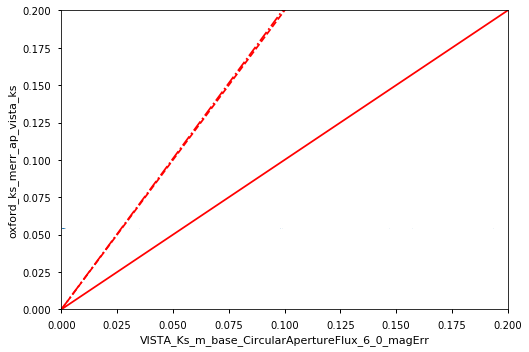

In [80]:
xName = 'VISTA_Ks_m_base_CircularApertureFlux_6_0_magErr'
yName = 'oxford_ks_merr_ap_vista_ks'
plt.scatter(
    3*merge[mask][xName],
    merge[mask][yName],
    s=0.1,
    alpha=0.2,rasterized=True)
plt.plot([0,1],[0,1], c='r')
plt.plot([0,1],[0,2], c='r', linestyle='--')
plt.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
plt.xlim([0,0.2])
plt.ylim([0,0.2])
plt.xlabel(xName)
plt.ylabel(yName)

Text(0, 0.5, 'oxford_ks_merr_ap_hsc_i')

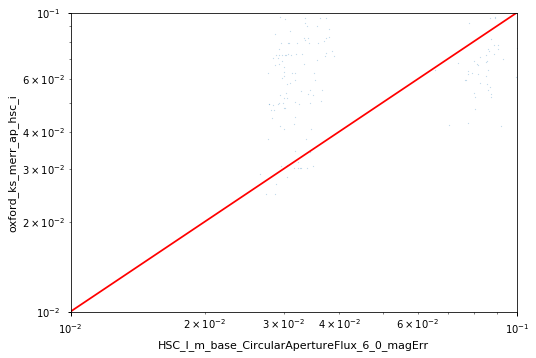

In [81]:
band='HSC_I'
xName = '{}_m_base_CircularApertureFlux_6_0_mag'.format(band)
yName = 'oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))
f, ferr = mag_to_flux(merge[mask][xName],merge[mask][xName.replace('mag','magErr')])
f_o, ferr_o = mag_to_flux((merge[mask][yName]
                           + oxfordApCorr['{}_2as'.format(band)]
                          ), # + oxfordApCorr['{}_2as'.format(band)],
                          merge[mask][yName.replace('_m_','_merr_')])
plt.scatter(
    ferr*1e6,
    ferr_o*1e6,
    s=1.,
    alpha=0.2,rasterized=True)
lims=[1.e-2,1.e-1]
plt.plot(lims,lims, c='r')
#plt.plot([0,1],[0,2], c='r', linestyle='--')
#plt.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
plt.xlim(lims)
plt.ylim(lims)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(xName.replace('mag','magErr'))
plt.ylabel(yName.replace('_m_','_merr_'))

Text(0, 0.5, 'oxford_ks_merr_ap_vista_ks')

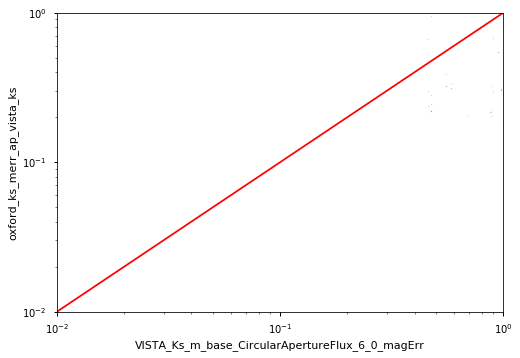

In [82]:
band='VISTA_Ks'
xName = '{}_m_base_CircularApertureFlux_6_0_mag'.format(band)
yName = 'oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))
f, ferr = mag_to_flux(merge[mask][xName],merge[mask][xName.replace('mag','magErr')])
f_o, ferr_o = mag_to_flux((merge[mask][yName]
                           + oxfordApCorr['{}_2as'.format(band)]
                          ), # + oxfordApCorr['{}_2as'.format(band)],
                          merge[mask][yName.replace('_m_','_merr_')])
plt.scatter(
    ferr*1e6,
    ferr_o*1e6,
    s=1.,
    alpha=0.2,rasterized=True)
lims=[1.e-2,1.e0]
plt.plot(lims,lims, c='r')
#plt.plot([0,1],[0,2], c='r', linestyle='--')
#plt.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
plt.xlim(lims)
plt.ylim(lims)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(xName.replace('mag','magErr'))
plt.ylabel(yName.replace('_m_','_merr_'))

Text(0, 0.5, 'oxford_ks_merr_ap_vista_ks')

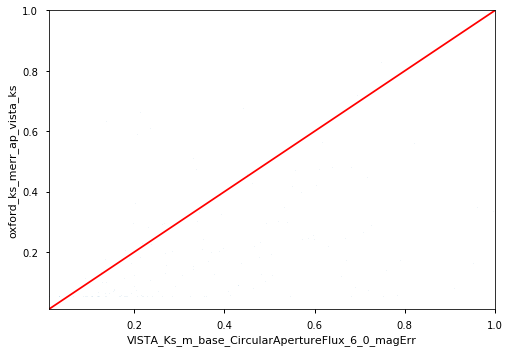

In [83]:
band='VISTA_Ks'
xName = '{}_m_base_CircularApertureFlux_6_0_mag'.format(band)
yName = 'oxford_ks_m_ap_{}'.format(band.lower().replace('-','_'))
f, ferr = mag_to_flux(merge[mask][xName],merge[mask][xName.replace('mag','magErr')])
f_o, ferr_o = mag_to_flux((merge[mask][yName]
                           + oxfordApCorr['{}_2as'.format(band)]
                          ), # + oxfordApCorr['{}_2as'.format(band)],
                          merge[mask][yName.replace('_m_','_merr_')])
plt.scatter(
    flux_to_mag(f*1e6,ferr*1e6)[1],
    flux_to_mag(f_o*1e6,ferr_o*1e6)[1],
    s=0.1,
    alpha=0.2,rasterized=True)
lims=[1.e-2,1.e0]
plt.plot(lims,lims, c='r')
#plt.plot([0,1],[0,2], c='r', linestyle='--')
#plt.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
plt.xlim(lims)
plt.ylim(lims)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel(xName.replace('mag','magErr'))
plt.ylabel(yName.replace('_m_','_merr_'))

In [84]:
np.sum(~np.isnan(ferr) & ~np.isnan(ferr_o))

237

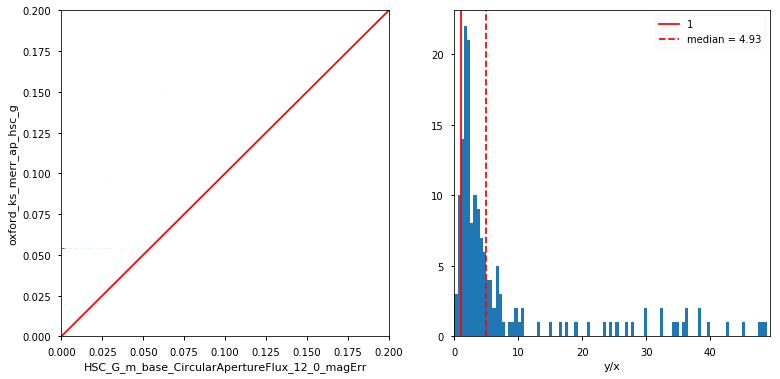

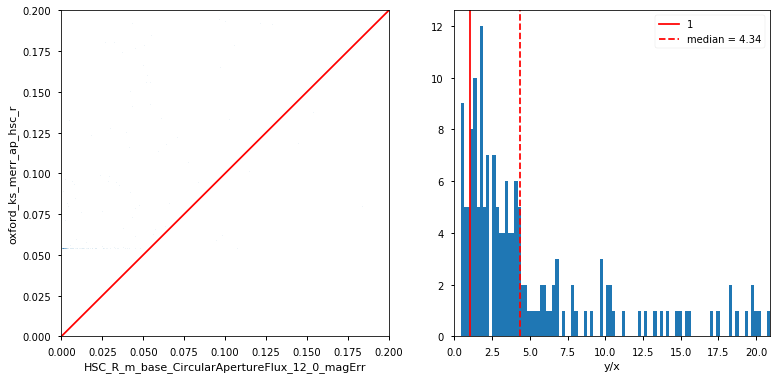

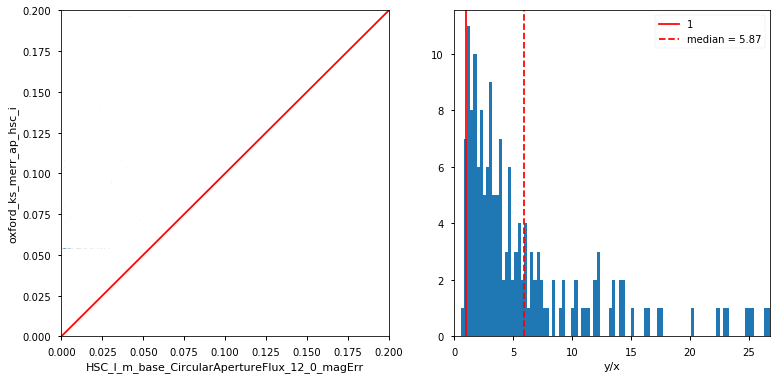

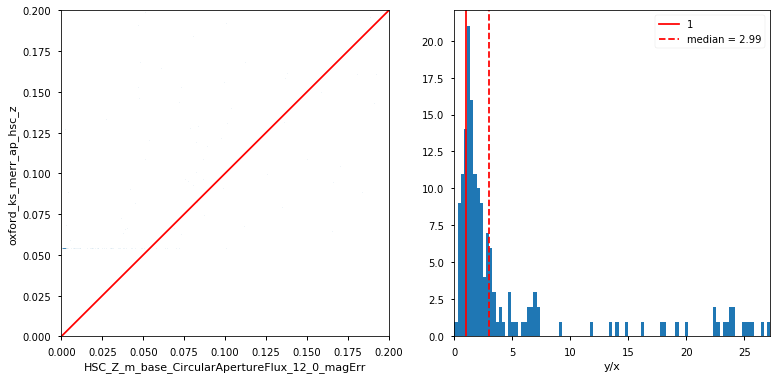

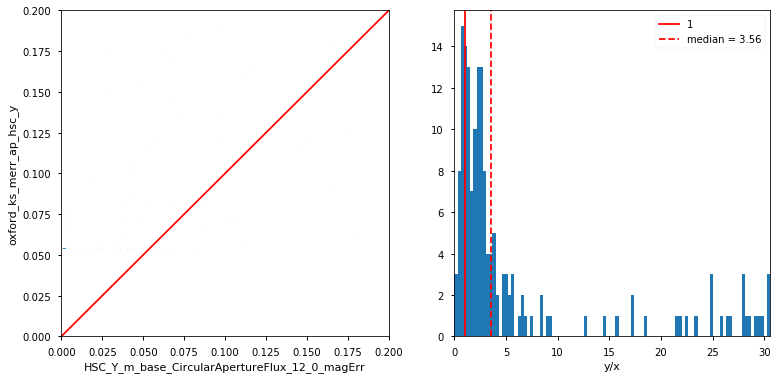

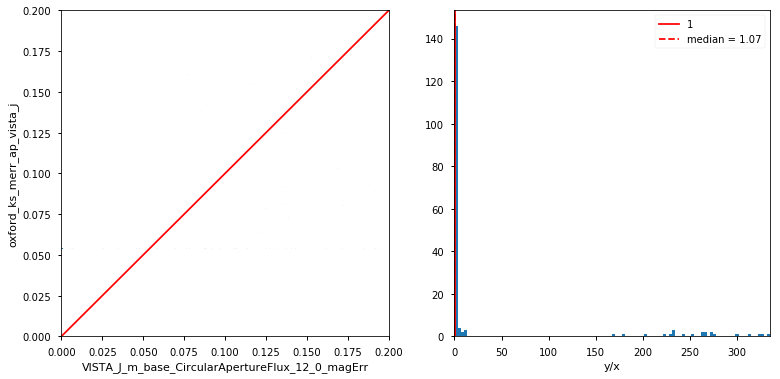

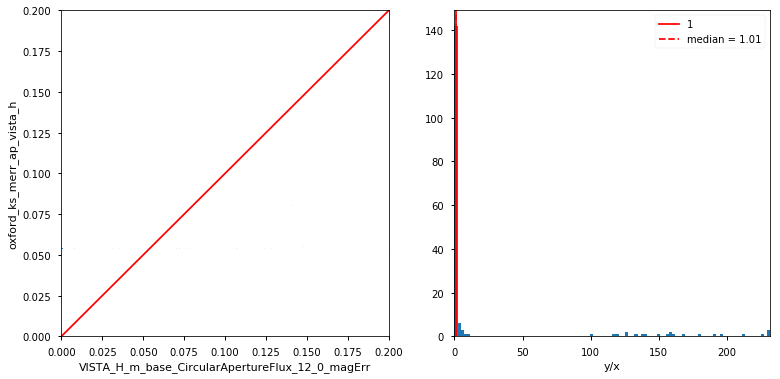

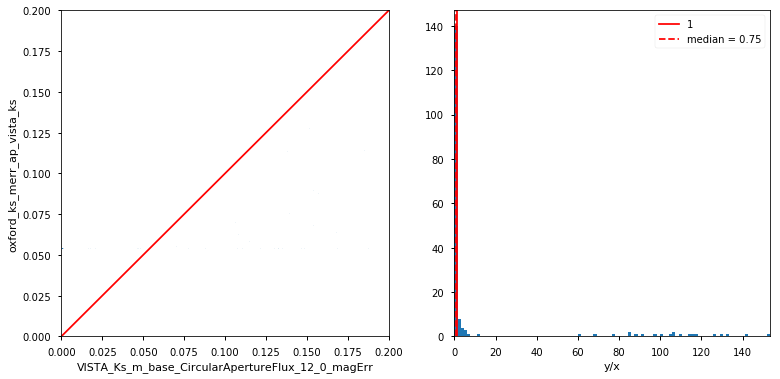

In [85]:
for b in allBands:
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    
    xName = '{}_m_base_CircularApertureFlux_12_0_magErr'.format(b)
    yName = 'oxford_ks_merr_ap_{}'.format(b.lower().replace('-','_'))
    ax1.scatter(
        merge[mask][xName],
        merge[mask][yName],
        s=0.1,
        alpha=0.2,rasterized=True)
    ax1.plot([0,1],[0,1], c='r')
    #ax1.plot([0,1],[0,2], c='r', linestyle='--')
    #ax1.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
    ax1.set_xlim([0,0.2])
    ax1.set_ylim([0,0.2])
    ax1.set_xlabel(xName)
    ax1.set_ylabel(yName)
    m = mask & (merge[yName]>0.05)
    med = np.nanmedian(merge[m][yName]/merge[m][xName])
    #mode=stats.mode(merge[mask][yName]/merge[mask][xName],nan_policy='omit',axis=None).mode[0]
    ax2.axvline(1,c='r', label='1')
    ax2.axvline(med,c='r', linestyle='--', label='median = {}'.format(round(med,2)))
    #ax2.axvline(med,c='r',linestyle='--', label='mode = {}'.format(round(mode,2)))
    ax2.legend()
    lims=[0,np.nanpercentile(merge[mask][yName]/merge[mask][xName],75.)]
    ax2.hist(
    merge[m][yName]/merge[m][xName],
    bins=100, range=lims)
    ax2.set_xlabel("y/x")
    ax2.set_xlim(lims)

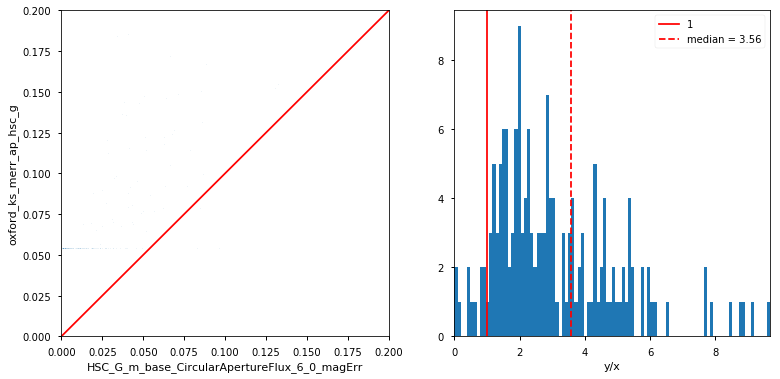

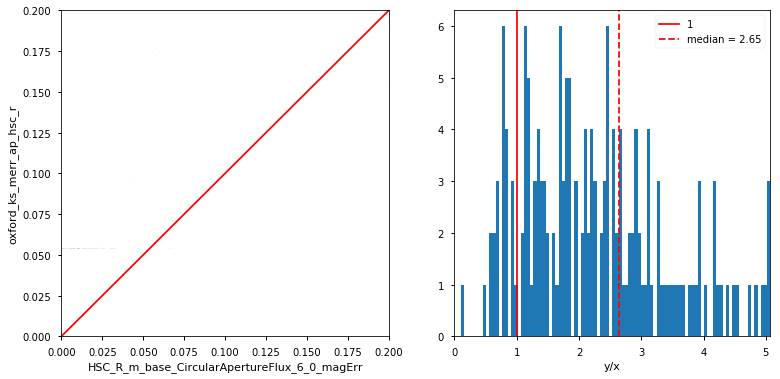

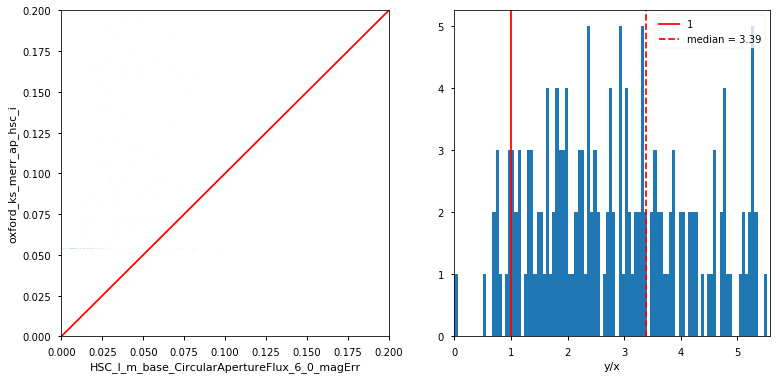

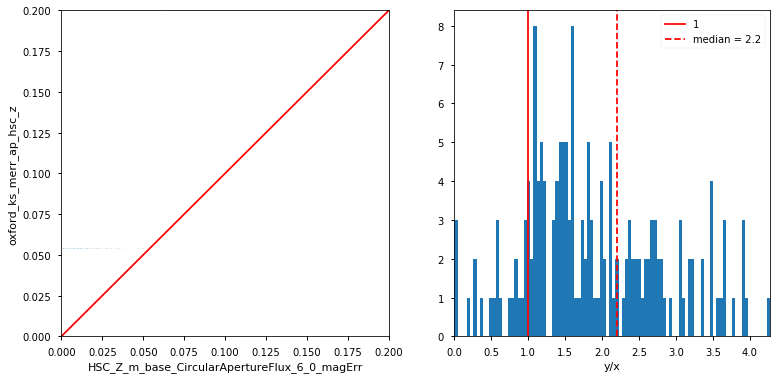

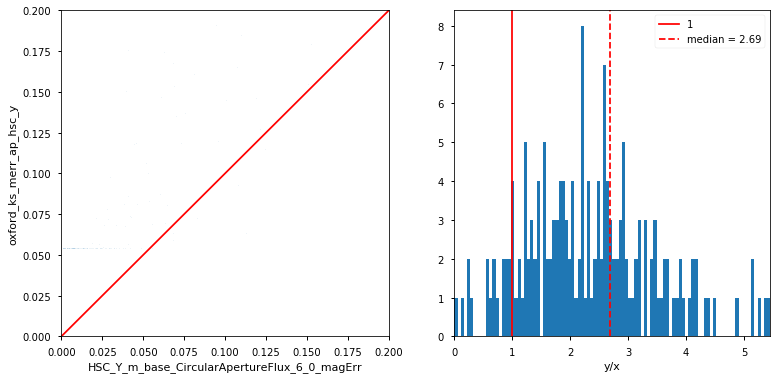

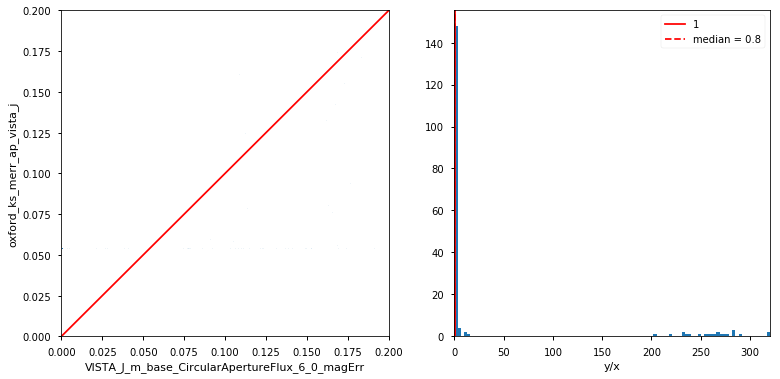

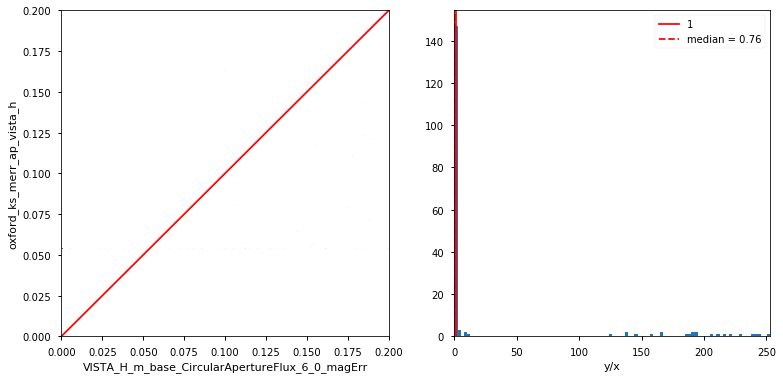

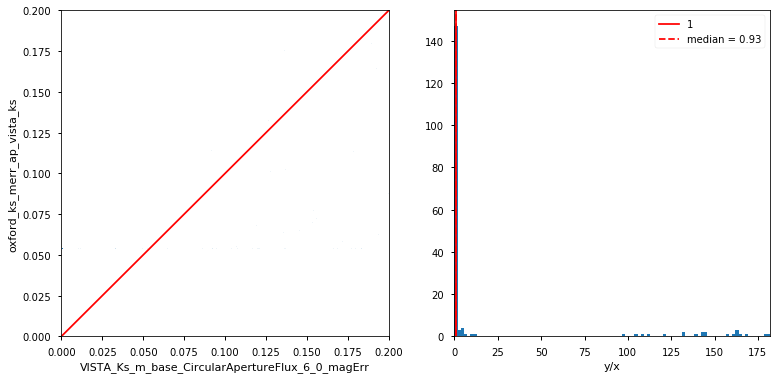

In [87]:
for b in allBands:
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    
    xName = '{}_m_base_CircularApertureFlux_6_0_magErr'.format(b)
    yName = 'oxford_ks_merr_ap_{}'.format(b.lower().replace('-','_'))
    ax1.scatter(
        merge[mask][xName],
        merge[mask][yName],
        s=0.1,
        alpha=0.2,rasterized=True)
    ax1.plot([0,1],[0,1], c='r')
    #ax1.plot([0,1],[0,2], c='r', linestyle='--')
    #ax1.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
    ax1.set_xlim([0,0.2])
    ax1.set_ylim([0,0.2])
    ax1.set_xlabel(xName)
    ax1.set_ylabel(yName)
    m = mask & (merge[yName]>0.05)
    med = np.nanmedian(merge[m][yName]/merge[m][xName])
    #mode=stats.mode(merge[mask][yName]/merge[mask][xName],nan_policy='omit',axis=None).mode[0]
    ax2.axvline(1,c='r', label='1')
    ax2.axvline(med,c='r',linestyle='--', label='median = {}'.format(round(med,2)))
    #ax2.axvline(med,c='r',linestyle='--', label='mode = {}'.format(round(mode,2)))
    ax2.legend()
    lims=[0,np.nanpercentile(merge[m][yName]/merge[m][xName],75.)]
    ax2.hist(
    merge[m][yName]/merge[m][xName],
    bins=100, range=lims)
    ax2.set_xlabel("y/x")
    ax2.set_xlim(lims)

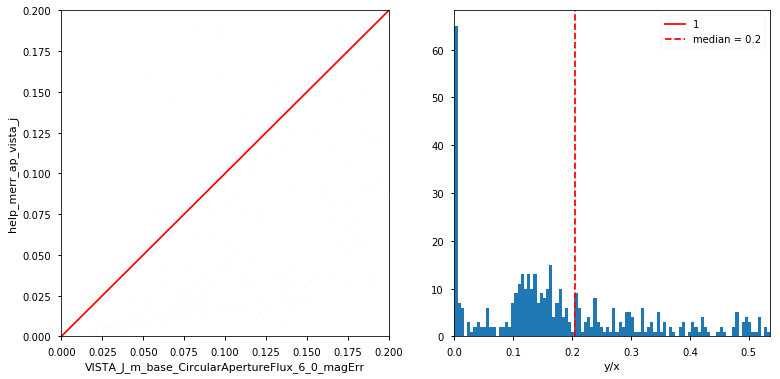

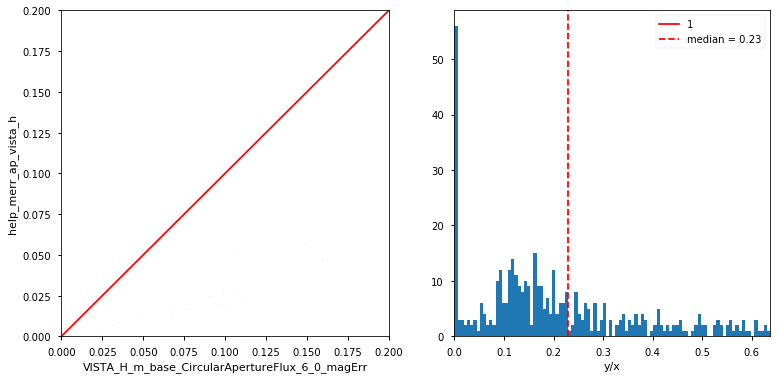

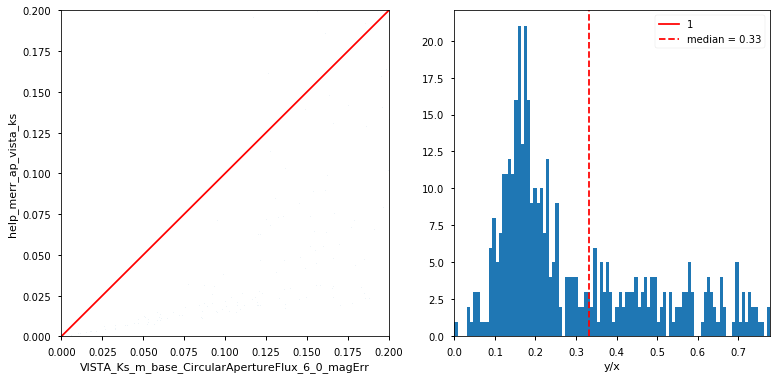

In [88]:
for b in allBands:
    if b.startswith('HSC'):
        continue
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    
    xName = '{}_m_base_CircularApertureFlux_6_0_magErr'.format(b)
    yName = 'help_merr_ap_{}'.format(b.lower().replace('-','_'))
    ax1.scatter(
        merge[mask][xName],
        merge[mask][yName],
        s=0.1,
        alpha=0.2,rasterized=True)
    ax1.plot([0,1],[0,1], c='r')
    #ax1.plot([0,1],[0,2], c='r', linestyle='--')
    #ax1.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
    ax1.set_xlim([0,0.2])
    ax1.set_ylim([0,0.2])
    ax1.set_xlabel(xName)
    ax1.set_ylabel(yName)
    m = mask #& (merge[yName]>0.05)
    med = np.nanmedian(merge[m][yName]/merge[m][xName])
    #mode=stats.mode(merge[mask][yName]/merge[mask][xName],nan_policy='omit',axis=None).mode[0]
    ax2.axvline(1,c='r', label='1')
    ax2.axvline(med,c='r',linestyle='--', label='median = {}'.format(round(med,2)))
    #ax2.axvline(med,c='r',linestyle='--', label='mode = {}'.format(round(mode,2)))
    ax2.legend()
    lims=[0,np.nanpercentile(merge[m][yName]/merge[m][xName],75.)]
    ax2.hist(
    merge[m][yName]/merge[m][xName],
    bins=100, range=lims)
    ax2.set_xlabel("y/x")
    ax2.set_xlim(lims)

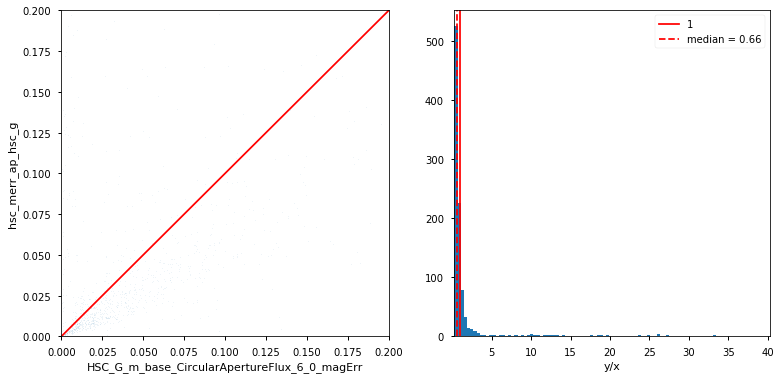

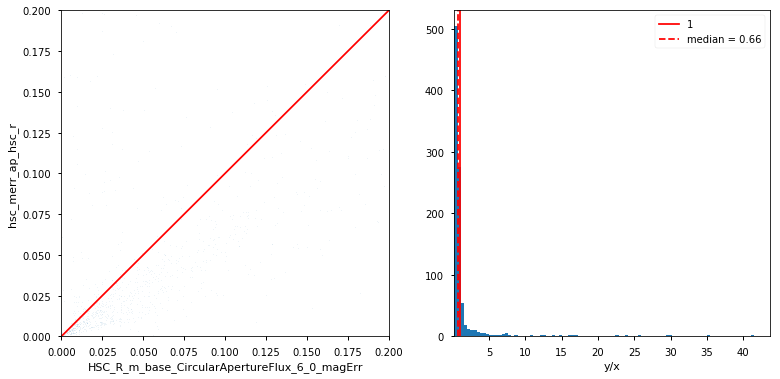

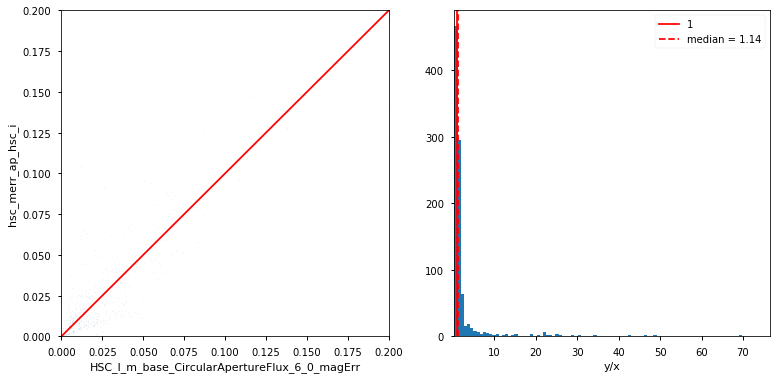

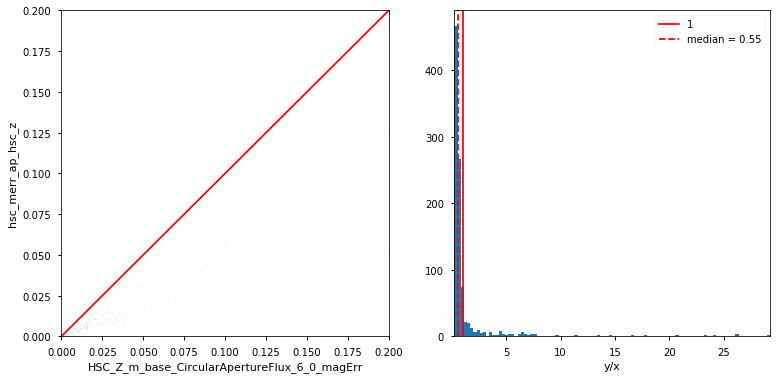

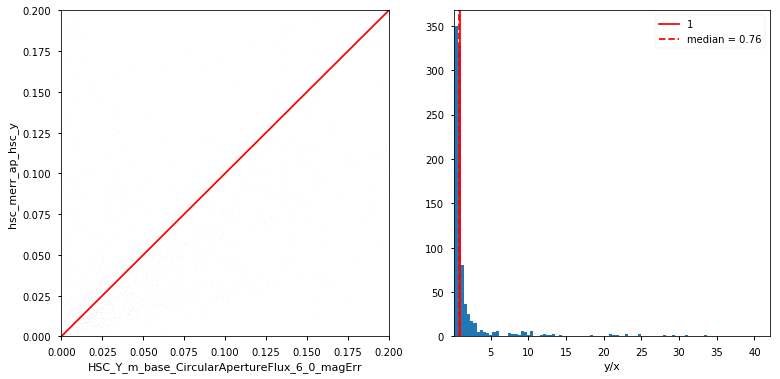

In [89]:
for b in allBands:
    if not b.startswith('HSC'):
        continue
    fig = plt.figure(figsize=(13, 6))

    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=0.4, wspace=0.05)
    ax1 = plt.subplot(gs1[:, :])

    gs2 = gridspec.GridSpec(1, 3)
    gs2.update(left=0.47, right=0.98, hspace=0.05, wspace=0.05)
    ax2 = plt.subplot(gs2[:, :-1])
    
    xName = '{}_m_base_CircularApertureFlux_6_0_magErr'.format(b)
    yName = 'hsc_merr_ap_{}'.format(b.lower().replace('-','_'))
    ax1.scatter(
        merge[mask][xName],
        merge[mask][yName],
        s=0.1,
        alpha=0.2,rasterized=True)
    ax1.plot([0,1],[0,1], c='r')
    #ax1.plot([0,1],[0,2], c='r', linestyle='--')
    #ax1.plot([0,1],[0,0.339/0.168], c='r', linestyle='-.')
    ax1.set_xlim([0,0.2])
    ax1.set_ylim([0,0.2])
    ax1.set_xlabel(xName)
    ax1.set_ylabel(yName)
    m = mask #& (merge[yName]>0.05)
    med = np.nanmedian(merge[m][yName]/merge[m][xName])
    #mode=stats.mode(merge[mask][yName]/merge[mask][xName],nan_policy='omit',axis=None).mode[0]
    ax2.axvline(1,c='r', label='1')
    ax2.axvline(med,c='r',linestyle='--', label='median = {}'.format(round(med,2)))
    #ax2.axvline(med,c='r',linestyle='--', label='mode = {}'.format(round(mode,2)))
    ax2.legend()
    lims=[np.nanpercentile(merge[m][yName]/merge[m][xName],5.),np.nanpercentile(merge[m][yName]/merge[m][xName],95.)]
    ax2.hist(
    merge[m][yName]/merge[m][xName],
    bins=100, range=lims)
    ax2.set_xlabel("y/x")
    ax2.set_xlim(lims)

Text(0, 0.5, 'LSST - Oxford [mag]')

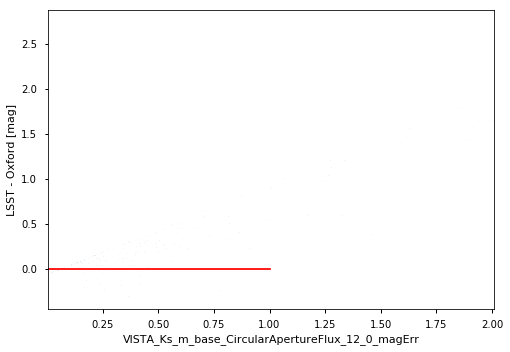

In [90]:
xName = 'VISTA_Ks_m_base_CircularApertureFlux_12_0_magErr'
yName = 'oxford_ks_merr_ap_vista_ks'
plt.scatter(
    merge[mask][xName],
    merge[mask][xName]-merge[mask][yName],
    s=0.1,
    alpha=0.2)
plt.plot([0,1],[0,0], c='r')
plt.xlim([
    np.nanpercentile(merge[mask][xName],2.5),
    np.nanpercentile(merge[mask][xName],97.5)])
plt.ylim([
    np.nanpercentile(merge[mask][xName]-merge[mask][yName],2.5),
    np.nanpercentile(merge[mask][xName]-merge[mask][yName],97.5)])
plt.xlabel(xName)
plt.ylabel("{} - {} [mag]".format('LSST', 'Oxford'))

Text(0, 0.5, 'LSST Err - Oxford Err [mag]')

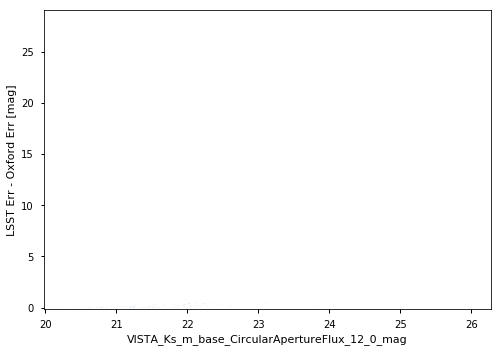

In [91]:

xName = 'VISTA_Ks_m_base_CircularApertureFlux_12_0_mag'
yName = 'oxford_ks_merr_ap_vista_ks'
yName2 = 'VISTA_Ks_m_base_CircularApertureFlux_12_0_magErr'
plt.scatter(
    merge[mask][xName],
    merge[mask][yName2]-merge[mask][yName],
    s=0.1,
    alpha=0.2)
plt.plot([0,1],[0,0], c='r')
plt.xlim([
    np.nanpercentile(merge[mask][xName],2.5),
    np.nanpercentile(merge[mask][xName],99.9)])
plt.ylim([
    np.nanpercentile(merge[mask][yName2]-merge[mask][yName],5.),
    np.nanpercentile(merge[mask][yName2]-merge[mask][yName],99.9)])
plt.xlabel(xName)
plt.ylabel("{} Err - {} Err [mag]".format('LSST', 'Oxford'))

## Astrometry

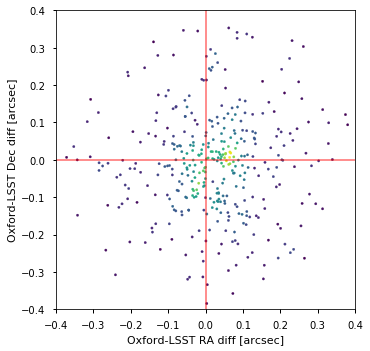

In [95]:
m = ~np.isnan(merge['oxford_ks_ra'])
m &= ~np.isnan(merge['VISTA_Ks_m_coord_ra'])
fig, ax = plt.subplots()
x=(merge[m]['oxford_ks_ra'].to(u.arcsec)-merge[m]['VISTA_Ks_m_coord_ra'].to(u.arcsec)).value
y=(merge[m]['oxford_ks_dec'].to(u.arcsec) - merge[m]['VISTA_Ks_m_coord_dec'].to(u.arcsec)).value
data , x_e, y_e = np.histogram2d( x,  x - y, bins = 20, density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
                data , np.vstack([x, x - y]).T, method = "splinef2d" , bounds_error = False)#, method = "splinef2d"

    #To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
if True :
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
ax.scatter(
    x, 
    y,
    c=z,
    s=5.5,alpha=1.,
    rasterized=True
)

#fig.colorbar(im, ax=ax, label="Number",fraction=0.046, pad=0.04)
ax.plot([-1,1],[0,0], c='r', alpha=0.5)
ax.plot([0,0],[-1,1], c='r', alpha=0.5)
ax.set_xlabel('Oxford-LSST RA diff [arcsec]')
ax.set_ylabel('Oxford-LSST Dec diff [arcsec]')
ax.set_aspect('equal')
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-0.4,0.4])

plt.savefig('./figs/astrometry_LSST_Oxford.pdf', bbox_inches='tight')
plt.savefig('./figs/astrometry_LSST_Oxford.png', bbox_inches='tight')

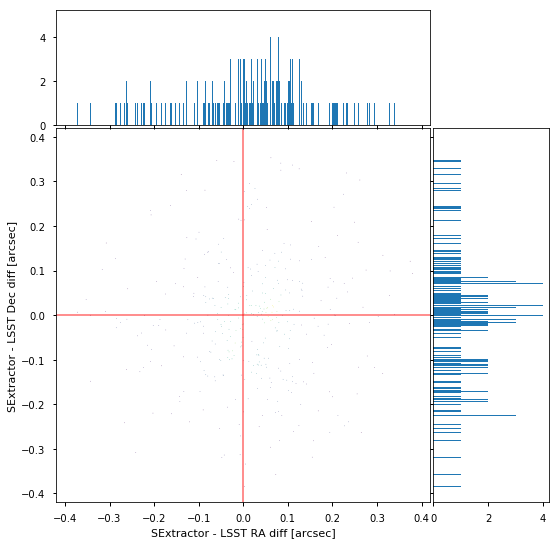

In [97]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    data , x_e, y_e = np.histogram2d( x,  x - y, bins = 20, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , 
                data , np.vstack([x, x - y]).T, method = "splinef2d" , bounds_error = False)#, method = "splinef2d"

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if True :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(
        x, 
        y,
        c=z,
        s=0.05,alpha=1.,
        rasterized=True
    )
    ax.plot([-1,1],[0,0], c='r', alpha=0.5)
    ax.plot([0,0],[-1,1], c='r', alpha=0.5)
    ax.set_xlabel('SExtractor - LSST RA diff [arcsec]')
    ax.set_ylabel('SExtractor - LSST Dec diff [arcsec]')
    ax.set_aspect('equal')
    ax.set_xlim([-0.42,0.42])
    ax.set_ylim([-0.42,0.42])
    # now determine nice limits by hand:
    binwidth = 0.001
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    
    
m = ~np.isnan(merge['oxford_ks_ra'])
m &= ~np.isnan(merge['VISTA_Ks_m_coord_ra'])

x=(merge[m]['oxford_ks_ra'].to(u.arcsec)-merge[m]['VISTA_Ks_m_coord_ra'].to(u.arcsec)).value
y=(merge[m]['oxford_ks_dec'].to(u.arcsec) - merge[m]['VISTA_Ks_m_coord_dec'].to(u.arcsec)).value    

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.savefig('./figs/astrometry_LSST_Oxford_marginal.pdf', bbox_inches='tight')
plt.savefig('./figs/astrometry_LSST_Oxford_matginal.png', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()


m = ~np.isnan(merge['oxford_ks_ra'])
m &= ~np.isnan(merge['VISTA_Ks_m_coord_ra'])



im = ax.hexbin(
    merge[m]['oxford_ks_ra'].to(u.arcsec)-merge[m]['VISTA_Ks_m_coord_ra'].to(u.arcsec), 
    merge[m]['oxford_ks_dec'].to(u.arcsec) - merge[m]['VISTA_Ks_m_coord_dec'].to(u.arcsec),  
    bins="log")#cmap='Oranges',, cmap='Greys'

fig.colorbar(im, ax=ax, label="Number",fraction=0.046, pad=0.04)

ax.plot([-1,1],[0,0], c='r', alpha=0.5)
ax.plot([0,0],[-1,1], c='r', alpha=0.5)
ax.set_xlabel('Oxford-LSST RA diff [arcsec]')
ax.set_ylabel('Oxford-LSST Dec diff [arcsec]')
ax.set_aspect('equal')
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-0.4,0.4])

plt.savefig('./figs/astrometry_LSST_Oxford_hexbin.pdf', bbox_inches='tight')
plt.savefig('./figs/astrometry_LSST_Oxford_hexbin.png', bbox_inches='tight')


In [98]:
np.median(merge[m]['oxford_ks_ra'].to(u.arcsec)-merge[m]['VISTA_Ks_m_coord_ra'].to(u.arcsec))

<Quantity 0.02447918 arcsec>

In [99]:
np.std(merge[m]['oxford_ks_ra'].to(u.arcsec)-merge[m]['VISTA_Ks_m_coord_ra'].to(u.arcsec))

<Quantity 0.13527995 arcsec>

In [100]:
np.median(merge[m]['oxford_ks_dec'].to(u.arcsec)-merge[m]['VISTA_Ks_m_coord_dec'].to(u.arcsec))

<Quantity -0.00850117 arcsec>

In [101]:
np.std(merge[m]['oxford_ks_dec'].to(u.arcsec)-merge[m]['VISTA_Ks_m_coord_dec'].to(u.arcsec))

<Quantity 0.14079218 arcsec>

##  Matches
Lets plot the density of objects in one, the other, or both catalogues to see differences in coverage

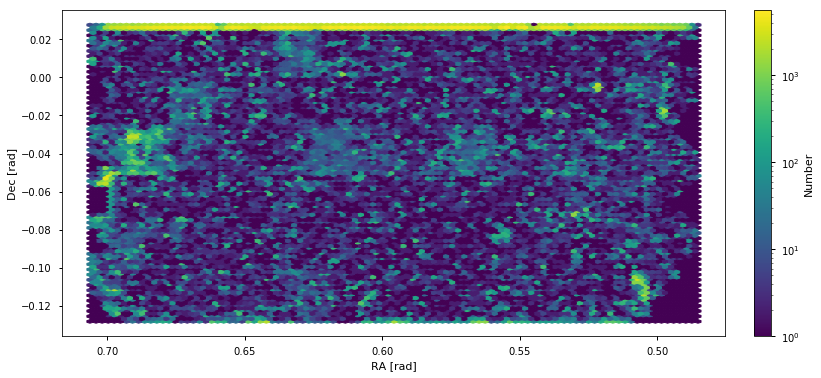

In [102]:
fig, ax = plt.subplots(figsize=(13, 6))

m = merge['oxford_ks_id']==999999




im = ax.hexbin(
    merge[m]['VISTA_Ks_m_coord_ra'], 
    merge[m]['VISTA_Ks_m_coord_dec'],  
    bins="log")#cmap='Oranges',, cmap='Greys'

fig.colorbar(im, ax=ax, label="Number",fraction=0.046, pad=0.04)
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.nanmax(merge[m]['VISTA_Ks_m_coord_ra'])+0.01, np.nanmin(merge[m]['VISTA_Ks_m_coord_ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/not_in_ox_density.pdf', bbox_inches='tight')
fig.savefig('./figs/not_in_ox_density.png', bbox_inches='tight')

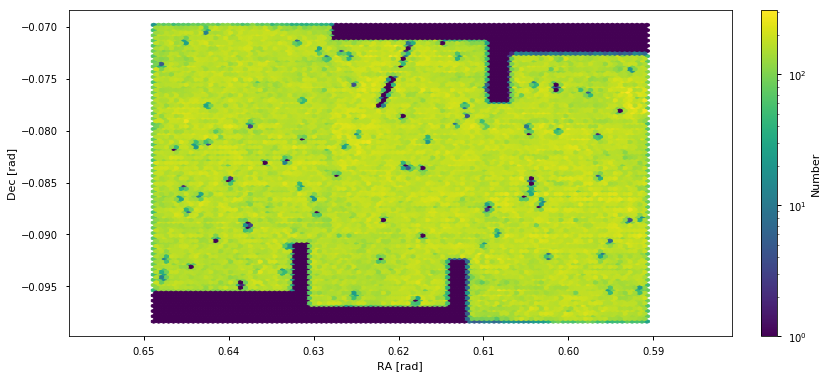

In [103]:
fig, ax = plt.subplots(figsize=(13, 6))

m = merge['id']==999999
m&=merge['oxford_ks_ra']>0



im = ax.hexbin(
    merge[m]['ra'], 
    merge[m]['dec'],  
    bins="log")#cmap='Oranges',, cmap='Greys'

fig.colorbar(im, ax=ax, label="Number",fraction=0.046, pad=0.04)
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.nanmax(merge[m]['ra'])+0.01, np.nanmin(merge[m]['ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/not_in_lsst_density.pdf', bbox_inches='tight')
fig.savefig('./figs/not_in_lsst_density.png', bbox_inches='tight')

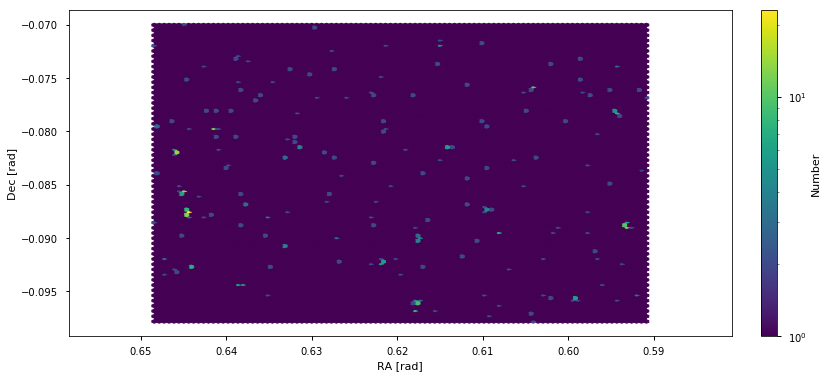

In [104]:
fig, ax = plt.subplots(figsize=(13, 6))

m = merge['id']!=999999
m&=merge['oxford_ks_ra']>0




im = ax.hexbin(
    merge[m]['ra'], 
    merge[m]['dec'],  
    bins="log")#cmap='Oranges',, cmap='Greys'

fig.colorbar(im, ax=ax, label="Number",fraction=0.046, pad=0.04)
ax.set_xlabel('RA [rad]')
ax.set_xlim([np.nanmax(merge[m]['ra'])+0.01, np.nanmin(merge[m]['ra'])-0.01])
ax.set_ylabel('Dec [rad]')
fig.savefig('./figs/in_both_density.pdf', bbox_inches='tight')
fig.savefig('./figs/in_both_density.png', bbox_inches='tight')